# Initialization for Notebook

Choose piglet below for which to run the different scenarios.

In [1]:
import os
import torch
import scipy.io
import matplotlib.pyplot as plt
import cvxpy as cp
import seaborn as sns
from scipy.signal import medfilt, savgol_filter, wiener
from tqdm import tqdm
import numpy as np

os.chdir('..')
import data_processing.preprocessing as preprocessing
from utils import beerlamb_multi

sns.set()

In [18]:
left_cut = 740
right_cut = 900

cut=1000 #at what timepoint to stop inference
max_b1 = 5

imgs = []
imgs_darkcount = []
imgs_whitecount = []
HI_starts = []
HI_stops = []
outcomes = []

#To find HI_start and HI_stop:
#we take the row in the Excel where FiO2 drops, but need to add offset as Excel file starts at different timepoint

# No shift in Excel File for this piglet :)
# img = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/lwp479-HI+saline/LWP479_Ws_05Dec2016.mat')
# img_darkcount = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/lwp479-HI+saline/LWP479_DarkCount_05Dec2016.mat')
# img_whitecount = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/lwp479-HI+saline/refSpectrum.mat')
# HI_start = 149
# HI_stop = 297
# outcome = 1

# Problematic Piglet
# img = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP480/LWP480_Ws_12Dec2016.mat')
# img_darkcount = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP480/LWP480_DarkCount_12Dec2016.mat')
# img_whitecount = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP480/refSpectrum.mat')
# HI_start = 275 + 78
# HI_stop = 399 + 78
# outcome = 1

# img = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP484/LWP484_Ws_23Jan2017.mat')
# img_darkcount = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP484/LWP484_DarkCount_23Jan2017.mat')
# img_whitecount = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP484/refSpectrum.mat')
# HI_start = 89 + 123
# HI_stop = 243 + 123
# outcome = 1

# img = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP488/LWP488_Ws_13Feb2017.mat')
# img_darkcount = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP488/LWP488_DarkCount_13Feb2017.mat')
# img_whitecount = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP488/refSpectrum.mat')
# HI_start = 139
# HI_stop = 282
# outcome = 0

img = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP498/LWP498_Ws_24Apr2017_15.mat')
img_darkcount = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP498/LWP498 _DarkCount_24Apr2017.mat')
img_whitecount = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP498/refSpectrum.mat')
HI_start = 143
HI_stop = 274
outcome = 0

# img = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP503/LWP503_Ws_05_Jun_2017_15   8.mat')
# img_darkcount = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP503/LWP503_DarkCount_05Jun2017.mat')
# img_whitecount = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP503/refSpectrum.mat')
# HI_start = 100
# HI_stop = 200

# img = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP504/LWP504_Ws_12Jun_2017_17   1.mat')
# img_darkcount = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP504/LWP504_DarkCount_12Jun2017.mat')
# img_whitecount = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP504/refSpectrum.mat')

# img = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP507/LWP507_Ws_10Jul_2017_16  55.mat')
# img_darkcount = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP507/LWP507_DarkCount_10Jul2017.mat')
# img_whitecount = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP507/refSpectrum.mat')

#img = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP512/LWP512_Ws_31Jul_2017_17  16.mat')
#img_darkcount = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP512/LWP512_DarkCount_31Jul2017.mat')
#img_whitecount = scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP512/refSpectrum.mat')

# Plot for EC (using scenario 2, see below) :)

@Ivan feel free to use a different scenario (see below, also creates some plots), as well as choosing a different piglet (see cell above, comment out the piglet you want)

In [3]:
import scipy
from scipy.linalg import pinv

def scenario_2_given_t1(img, img_darkcount, img_whitecount, b_i_t1, need_plot=True, plot_only_concentrations=False, include_water=False):
    #Initialization
    
    wavelengths = img['wavelengths'].astype(float)
    white_full = img_whitecount['refSpectrum'].astype(float)
    dark_full = img_darkcount['DarkCount'].astype(float)
    spectr = img['spectralDataAll'].astype(float)

    concentrations_paper = img['AllConcentration']
    
    idx = (wavelengths >= left_cut) & (wavelengths <= right_cut)
    wavelengths = wavelengths[idx]
    spectr = spectr[idx.squeeze()]
    dark_full = dark_full[idx.squeeze()]
    white_full = white_full[idx.squeeze()]

    reference_index = 0
    ref_spectr = (spectr[:, reference_index] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])

    if need_plot:
        plt.figure()
        plt.plot(wavelengths, ref_spectr)
        plt.title("Reference spectrum")
    
    molecules, x = preprocessing.read_molecules(left_cut, right_cut, wavelengths)
    y_hbo2_f, y_hb_f, y_coxa, y_creda, y_water, y_fat, y_cytoa_diff, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red = molecules

    if include_water:
        M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                    np.asarray(y_hb_f),
                                    np.asarray(y_coxa - y_creda),
                                    np.asarray(y_water))))        
    else:
        M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                    np.asarray(y_hb_f),
                                    np.asarray(y_coxa - y_creda))))
    #                                np.asarray(y_water))))

    M_pinv = pinv(M)
    m=M.shape[1]

    if need_plot:
        plt.figure()
        coef = ["HbO2", "Hbb", "oxyCCO diff", "oxyCCO diff official", "oxy cytoc", "red cytoc", "cytob oxy", "cytob red"]
        coef_list = [y_hbo2_f, y_hb_f, y_coxa-y_creda, y_cytoa_diff, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red]
        for i in range(len(coef)):
            plt.plot(wavelengths, coef_list[i], label=coef[i], linewidth=2)
        
        plt.title("Spectra Overview")
        plt.legend(loc=(1.1,0))
        
        plt.figure()
        colors = ['cyan', 'yellow']
        coef = ["water", "fat"]
        coef_list = [y_water, y_fat]
        for i in range(len(coef)):
            plt.plot(wavelengths, coef_list[i], color=colors[i], label=coef[i], linewidth=2)
        plt.legend()
    
    #Define helper functions
    def plot_concentrations_paper(concentrations):
        plt.figure(figsize=(16,9))
        coef_list = np.vstack(concentrations)
        colors = ['#ff7f0e', '#1f77b4', '#2ca02c','#d62728']
        coef = ["Hbb","HbO2","diff oxyCCO","HbT"]
        
        for i in range(len(coef)):
            plt.plot(coef_list[:cut, i], label=coef[i], color=colors[i], linewidth=2)
            
        plt.title("Concentrations inferred in Paper")
        plt.xlabel("t")
        plt.ylabel("Concentration")
        plt.legend()
             
    def plot_concentrations(coef_list, a_s, title):
        plt.figure(figsize=(16,9))
        coef_list = np.vstack(coef_list)
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        coef = ["HbO2", "Hbb","diff oxyCCO","water","diff cc red","fat"]
        
        for i in range(m):
            if coef[i] == "water" or coef[i] == "fat":
                plt.plot(coef_list[:, i]/20, label=coef[i]+"/20", linewidth=2)
            else:
                plt.plot(coef_list[:, i], label=coef[i], linewidth=2)
            
        plt.plot(coef_list[:, 0] + coef_list[:,1], color='#d62728', label="HbT",linewidth=2)
        plt.title(title)
        plt.xlabel("t")
        plt.ylabel("Concentration")
        plt.legend()
        
        if len(a_s)>0: 
            a_s = np.vstack(a_s)
            plt.figure()
            plt.plot(a_s[:, 0], label="a_1", linewidth=0.5, color='purple')
            plt.title(title)
            plt.legend()
    
    def plot_a_b(a_s, b_s):
        plt.figure()
        b_s = np.vstack(b_s)
        plt.figure()
        plt.plot(b_s[:, 0], label="b", linewidth=2)
        plt.title("Inferred b(t)")
        plt.xlabel("t")
        plt.ylabel("b(t)")
    
    def S(b_i, b_i_t1):
        result = ((((wavelengths/500)**(-b_i[0]))) - (((wavelengths/500)**(-b_i_t1[0])))) / (1-0.9)
        return result
    
    def f(X,*arg):
        b = arg[0]
        b_i_t1 = arg[1]
        delta_c_i = X[:m]
        b_i = X[m:(m+1)]
        return (M @ delta_c_i) + S(b_i, b_i_t1) - b
        
    def optimisation_pinv(spectr1, spectr2):
        b = spectr2 / spectr1
        b = np.log(1 / np.asarray(b))
        X = M_pinv @ b
        found_spectrum = np.exp(-(M @ X)) * spectr1
        
        error = np.linalg.norm((((M @ X)) - b))
        
        return X, b, found_spectrum, error

    def optimisation_scattering_pinv(spectr1, spectr2, b_1):
        S = ((((wavelengths[...,None]/500)**(-b_1)))) / (1 - 0.9)
        M_S = np.hstack((M,S))
        M_S_pinv = pinv(M_S)
        b = spectr2 / spectr1
        b = np.log(1 / np.asarray(b))
        X = M_S_pinv @ b
        delta_c_i = X[0:m]
        delta_g_i_times_a_i = X[m:]
        found_spectrum = np.exp(-((M @ delta_c_i) + (S @ delta_g_i_times_a_i))) * spectr1
    
        error = np.linalg.norm(((((M @ delta_c_i) + (S @ delta_g_i_times_a_i))) - b))
    
        return X, b, found_spectrum, error
    
    def run_opti_b1(b_1):
        errors = []
        errors_no_scatter = []
        for i in range(1, cut+1):
            spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
            spectr2[spectr2 <= 0] = 0.0001    
            b = spectr2 / ref_spectr
            b = np.log(1 / np.asarray(b))
            _, _, _, error_no_scatter = optimisation_pinv(ref_spectr, spectr2)
            _, _, _, error = optimisation_scattering_pinv(ref_spectr, spectr2, b_1)
            errors.append(error)
            errors_no_scatter.append(error_no_scatter)
        return sum(errors), sum(errors_no_scatter)

    def plot_errors(no_scatter, scatter_fixed_b1, scatter, min_b1):
        plt.figure()
        x = np.array([0,1,2])
        #x = np.array([0,1])
        y = (np.array([no_scatter, scatter_fixed_b1, scatter]) - no_scatter) / no_scatter
        #y = (np.array([no_scatter, scatter_fixed_b1]) - no_scatter) / no_scatter
        my_xticks = ['No Scatter','Scatter b_1 = '+str(round(min_b1,2)), 'Scatter b_1(t)']
        #my_xticks = ['No Scatter','Scatter b_1 = '+str(round(min_b1,2))]
        plt.xticks(x, my_xticks)
        plt.plot(x,y)
        plt.ylabel("Error: Percentage Change")
    
    spectra_list = []
    coef_list = []
    b_s = []
    a_s = []
    
    coef_list_no_scatter = []
    
    coef_list_min_b1 = []
    a_s_min_b1 = []

    errors_no_scatter = []
    errors_scatter = []
    errors_scatter_min_b1 = []
    
    #initial_estimation = [0,0,0,0,1]
    current_x = np.zeros(m+1)
    current_x[-1] = 1
    #left_bound = [-np.inf,-np.inf,-np.inf,-np.inf,-1,0]
    left_bound = np.append(np.ones(m)*(-np.inf), [0])
    #right_bound = [np.inf,np.inf,np.inf,np.inf,1,0.2]
    right_bound = np.append(np.ones(m)*np.inf, [max_b1])
    
    for i in range(1, cut+1):
        #ref_spectr = (spectr[:, i-1] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
        spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
        spectr2[spectr2 <= 0] = 0.0001    
        b = spectr2 / ref_spectr
        b = np.log(1 / np.asarray(b))
        result = scipy.optimize.least_squares(f, current_x, args=(b, b_i_t1), bounds=(left_bound, right_bound))
        result_no_scatter, _, found_spectrum_noscatter, error_no_scatter = optimisation_pinv(ref_spectr, spectr2)
        #coefs_min_b1, _, found_spectrum_min_b1, error_scatter_min_b1 = optimisation_scattering_pinv(ref_spectr, spectr2, min_b1)
        current_x = result.x
        coef_list.append(result.x[:m])

        coef_list_no_scatter.append(result_no_scatter)
        
        b_s.append(result.x[m])

        errors_no_scatter.append(error_no_scatter)
        errors_scatter.append(np.sqrt(2*result.cost))
    
        found_attenuation = f(result.x, *(0,b_i_t1))
        
        if need_plot and i % 50 == 0:
            ######### Plots attenuation ##########
            plt.figure()
            plt.plot(wavelengths, -np.log(spectr2 / ref_spectr), label='GT Attenuation', linewidth=0.75)
            plt.plot(wavelengths, -np.log(found_spectrum_noscatter / ref_spectr), label='Simulated Attenuation (No Scattering)', linewidth=3)
            plt.plot(wavelengths, found_attenuation, label='Simulated Attenuation (With Scattering b_1(t))', linewidth=3)
            plt.title("Attenuations at t=" + str(i))
            plt.xlabel("Wavelength")
            plt.ylabel("Attenuation")
            plt.legend(loc=(1.04, 0))
            ######## Plots spectra ########
            plt.figure()
            plt.plot(wavelengths, spectr2, label='GT Spectrum', linewidth=2)
            plt.plot(wavelengths, found_spectrum_noscatter, label='Simulated Spectrum (No Scattering)', linewidth=3, alpha=0.6)
            plt.plot(wavelengths, ref_spectr * np.exp(-found_attenuation), label='Simulated Spectrum (With Scattering b_1(t))', linewidth=3, alpha=0.6)
            plt.title("Spectrogram at t=" + str(i))
            plt.xlabel("Wavelength")
            plt.ylabel("Spectra")
            plt.legend(loc=(1.04, 0))

    if need_plot:
        plot_concentrations_paper(concentrations_paper)
        plot_concentrations(coef_list_no_scatter, [], "Inferred Concentrations (No Scattering)")
        plot_concentrations(coef_list, [], "Inferred Concentrations (With Scattering b_1(t))")
        plot_a_b([],b_s)

    if not need_plot and plot_only_concentrations:
        plot_concentrations_paper(concentrations_paper)
        plot_concentrations(coef_list, [], "Scenario 2 - Computed With Scattering b_1(t)")
        plot_a_b([],b_s)
    return sum(errors_no_scatter), sum(errors_scatter)

def scenario_2_search_t1(img, img_darkcount, img_whitecount, need_plot=True, include_water=False):
    bs_i_t1 = np.linspace(0, max_b1, 50)
    
    min_val = np.zeros(bs_i_t1.shape)
    
    for i in tqdm(range(len(bs_i_t1))):
        min_val[i] = scenario_2_given_t1(img, img_darkcount, img_whitecount, [bs_i_t1[i]], need_plot=False, include_water=include_water)[1]
        #print(bs_i_t1[i], min_val[i])

    if need_plot:
        plt.plot(bs_i_t1, min_val)
        plt.xlabel("b_1(t_1)")
        plt.ylabel("Error")

    min_val_index = np.unravel_index(min_val.argmin(), min_val.shape)
    #print(min_val_index)
    return bs_i_t1[min_val_index]

min_b1 = scenario_2_search_t1(img, img_darkcount, img_whitecount, need_plot=False)
scenario_2_given_t1(img, img_darkcount, img_whitecount, [min_b1], need_plot=True)

  2%|▉                                           | 1/50 [00:03<03:05,  3.79s/it]


KeyboardInterrupt: 

# Scattering Notebook

We want to learn whether and how we can include scattering into the
Beer-Lambert Law. We remember that we can describe the modified Beer
Lambert law as
$$
A(t,\lambda)=\sum_{i}\mu_{i}(\lambda)\cdot c_{i}\cdot\text{PL}(\lambda)+G(\lambda)
$$
When we assume that scattering does not change in time, it is possible
to use the differential modified Beer Lambert law (dMBLL) to infer
the concentrations as
$$
\Delta A\left(\Delta t,\lambda\right)=A(t_{1},\lambda)-A(t_{0},\lambda)=\text{PL}(\lambda)\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}
$$
cancelling time-independent scattering effects. To improve upon this
model, we now assume that there are time-dependent scattering effects
such that 
$$
A(t,\lambda)=\text{PL}(\lambda)\left(\mu_{a}(t,\lambda)+\mu_{s}(t,\lambda)\right)=\text{PL}(\lambda)\left(\sum_{i}\mu_{i}(\lambda)\cdot c_{i}(t)+\mu_{s}(t,\lambda)\right)
$$
of the form
$$
\mu_{s}(t,\lambda)=G(\lambda)+\sum_{k}a_{k}(t)\cdot\left(\frac{\lambda}{500nm}\right)^{-b_{k}(t)}
$$
based on \cite{Oshina2021,Jacques2013}. This yields a new version
of the dMBLL as
$$
\Delta A(t,\lambda)=\text{PL}(\lambda)\left(\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}(t)+\mu_{s}(t_{2},\lambda)-\mu_{s}(t_{1},\lambda)\right)
$$
If we assume that the majority of the scattering originates from time-independent
factors, we might assume
$$
\mu_{s}(t,\lambda)=G(\lambda)+a_{1}(t)\cdot\left(\frac{\lambda}{500nm}\right)^{-b_{1}(t)}
$$
such that
$$
\Delta A(t,\lambda)=\text{PL}(\lambda)\left(\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}(t)+a(t_{2})\cdot\left(\frac{\lambda}{500nm}\right)^{-b(t_{2})}-a(t_{1})\cdot\left(\frac{\lambda}{500nm}\right)^{-b(t_{1})}\right)
$$
We want to test the following scenarios:
1. The most general case where both $a(t)$ and $b(t)$ vary in time, such that for each measured timepoint $t_i$ the parameters $a(t_i), b(t_i)$ need to be inferred, including a scattering estimate for the reference time $a(t_1),b(t_1)$. This is a challenging scenario as it presents high parameter ambiguity.

2. Let $a(t_{i})=a(t_{1})=a$. Time-dependent
scattering might change the scattering behavior, i.e. the wavelength
dependency $b(t)$, rather than changing the scattering probability
$a(t)$. The scattering probability is increased when tissue becomes
homogeneously denser {[}TODO: citation{]}, however during and after
HI we expect tissue changes that alter scattering behavior. With this
assumption, the problem in each timestep remains non-linear. The simplified
problem can be formulated as
$$
\Delta A(t,\lambda)=\text{PL}(\lambda)\left(\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}(t)+a\left[\left(\frac{\lambda}{500nm}\right)^{-b(t_{2})}-\left(\frac{\lambda}{500nm}\right)^{-b(t_{1})}\right]\right)
$$
For each timepoint we estimate $b(t_i)$. We empirically observed that different values of $a$ essentially scale $b(t_2)$, therefore we choose $a=1$ for simplicity.

3. Let $b(t_{i})=b(t_{1})=b$. Even though this might
not be a physically relevant case, it greatly simplifies problem complexity
as the problem then becomes linear after optimization of $b$, since
$$
\Delta A(t,\lambda)=\text{PL}(\lambda)\left(\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}(t)+\Delta a\left(\frac{\lambda}{500nm}\right)^{-b}\right)
$$

4. Let $a(t_1)=0$ such that we assume the absence of scattering at the beginning of measurement. This yields
$$
\Delta A(t,\lambda)=\text{PL}(\lambda)\left(\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}(t)+a(t_{2})\cdot\left(\frac{\lambda}{500nm}\right)^{-b(t_{2})}\right)
$$

As wavelength range we use $[740nm,900nm]$ as it shows significantly better fits below $760nm$ as we will observe below. For simplicity we assume $\text{PL}(\lambda)=1$.

We first go through the four scenarios for the piglet chosen above and then compute the error for a subset of the piglets to quantitatively compare the four cases.

# Scenario 1

We find parameters $a(t_i), b(t_i)$ for
$$
\Delta A(t,\lambda)=\text{PL}(\lambda)\left(\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}(t)+a(t_{2})\cdot\left(\frac{\lambda}{500nm}\right)^{-b(t_{2})}-a(t_{1})\cdot\left(\frac{\lambda}{500nm}\right)^{-b(t_{1})}\right)
$$

We examine scenario 1 by optimizing for different values of $a(t_1), b(t_1)$ and then pick the minimal $a(t_1), b(t_1)$ that was found to show the inference results, including the found fit for the observed absorption and the inferred concentrations.

In [ ]:
import scipy
from scipy.linalg import pinv

def scenario_1_given_t1(img, img_darkcount, img_whitecount, b_i_t1, G_tilde_t1, need_plot=True, plot_only_concentrations=False):

    #Initialization
    wavelengths = img['wavelengths'].astype(float)
    white_full = img_whitecount['refSpectrum'].astype(float)
    dark_full = img_darkcount['DarkCount'].astype(float)
    spectr = img['spectralDataAll'].astype(float)

    concentrations_paper = img['AllConcentration']
    
    idx = (wavelengths >= left_cut) & (wavelengths <= right_cut)
    wavelengths = wavelengths[idx]
    spectr = spectr[idx.squeeze()]
    dark_full = dark_full[idx.squeeze()]
    white_full = white_full[idx.squeeze()]

    reference_index = 0
    ref_spectr = (spectr[:, reference_index] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])

    if need_plot:
        plt.figure()
        plt.plot(wavelengths, ref_spectr)
        plt.title("Reference spectrum")
    
    molecules, x = preprocessing.read_molecules(left_cut, right_cut, wavelengths)
    y_hbo2_f, y_hb_f, y_coxa, y_creda, y_water, y_fat, y_cytoa_diff, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red = molecules
    M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                np.asarray(y_hb_f),
                                np.asarray(y_coxa - y_creda))))
    M_pinv = pinv(M)
    m=M.shape[1]

    if need_plot:
        plt.figure()
        coef = ["HbO2", "Hbb", "oxyCCO diff", "oxyCCO diff official", "oxy cytoc", "red cytoc", "cytob oxy", "cytob red"]
        coef_list = [y_hbo2_f, y_hb_f, y_coxa-y_creda, y_cytoa_diff, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red]
        for i in range(len(coef)):
            plt.plot(wavelengths, coef_list[i], label=coef[i], linewidth=2)
        
        plt.title("Spectra Overview")
        plt.legend(loc=(1.1,0))
        
        plt.figure()
        colors = ['cyan', 'yellow']
        coef = ["water", "fat"]
        coef_list = [y_water, y_fat]
        for i in range(len(coef)):
            plt.plot(wavelengths, coef_list[i], color=colors[i], label=coef[i], linewidth=2)
        plt.legend()
    
    #Define helper functions
    def plot_concentrations_paper(concentrations):
        plt.figure(figsize=(16,9))
        coef_list = np.vstack(concentrations)
        colors = ['#ff7f0e', '#1f77b4', '#2ca02c','#d62728']
        coef = ["Hbb","HbO2","diff oxyCCO","HbT"]
        
        for i in range(len(coef)):
            plt.plot(coef_list[:cut, i], label=coef[i], color=colors[i], linewidth=2)
            
        plt.title("Concentrations inferred in Paper")
        plt.legend()
             
    def plot_concentrations(coef_list, a_s, title):
        plt.figure(figsize=(16,9))
        coef_list = np.vstack(coef_list)
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        coef = ["HbO2", "Hbb","diff oxyCCO","diff cc red","water","fat"]
        
        for i in range(m):
            if coef[i] == "water" or coef[i] == "fat":
                plt.plot(coef_list[:, i]/10, label=coef[i]+"/10", linewidth=2)
            else:
                plt.plot(coef_list[:, i], label=coef[i], linewidth=2)
            
        plt.plot(coef_list[:, 0] + coef_list[:,1], color='#d62728', label="HbT",linewidth=2)
        plt.title(title)
        plt.legend()
        
        if len(a_s)>0: 
            a_s = np.vstack(a_s)
            plt.figure()
            plt.plot(a_s[:, 0], label="a_1", linewidth=0.5, color='purple')
            plt.title(title)
            plt.legend()
    
    def plot_a_b(a_s, b_s):
        plt.figure()
        b_s = np.vstack(b_s)
        plt.figure()
        plt.plot(b_s[:, 0], label="b", linewidth=2)
    
    def S(G_tilde, b_i, b_i_t1, G_tilde_t1):
        result = ((((wavelengths[...,None]/500)**(-b_i[0])) @ G_tilde) - (((wavelengths[...,None]/500)**(-b_i_t1[0])) @ G_tilde_t1)) / (1-0.9)
        return result
    
    def f(X,*arg):
        b = arg[0]
        b_i_t1, G_tilde_t1 = arg[1], arg[2]
        delta_c_i = X[:m]
        G_tilde_i = X[m:(m+1)]
        b_i = X[(m+1):(m+2)]  
        return (M @ delta_c_i) + S(G_tilde_i, b_i, b_i_t1, G_tilde_t1) - b
        
    def optimisation_pinv(spectr1, spectr2):
        b = spectr2 / spectr1
        b = np.log(1 / np.asarray(b))
        X = M_pinv @ b
        found_spectrum = np.exp(-(M @ X)) * spectr1
        
        error = np.linalg.norm((((M @ X)) - b))
        
        return X, b, found_spectrum, error

    def optimisation_scattering_pinv(spectr1, spectr2, b_1):
        S = ((((wavelengths[...,None]/500)**(-b_1)))) / (1 - 0.9)
        M_S = np.hstack((M,S))
        M_S_pinv = pinv(M_S)
        b = spectr2 / spectr1
        b = np.log(1 / np.asarray(b))
        X = M_S_pinv @ b
        delta_c_i = X[0:m]
        delta_g_i_times_a_i = X[m:]
        found_spectrum = np.exp(-((M @ delta_c_i) + (S @ delta_g_i_times_a_i))) * spectr1
    
        error = np.linalg.norm(((((M @ delta_c_i) + (S @ delta_g_i_times_a_i))) - b))
    
        return X, b, found_spectrum, error
    
    def run_opti_b1(b_1):
        errors = []
        errors_no_scatter = []
        for i in range(1, cut+1):
            spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
            spectr2[spectr2 <= 0] = 0.0001    
            b = spectr2 / ref_spectr
            b = np.log(1 / np.asarray(b))
            _, _, _, error_no_scatter = optimisation_pinv(ref_spectr, spectr2)
            _, _, _, error = optimisation_scattering_pinv(ref_spectr, spectr2, b_1)
            errors.append(error)
            errors_no_scatter.append(error_no_scatter)
        return sum(errors), sum(errors_no_scatter)

    def plot_errors(no_scatter, scatter_fixed_b1, scatter, min_b1):
        plt.figure()
        x = np.array([0,1,2])
        #x = np.array([0,1])
        y = (np.array([no_scatter, scatter_fixed_b1, scatter]) - no_scatter) / no_scatter
        #y = (np.array([no_scatter, scatter_fixed_b1]) - no_scatter) / no_scatter
        my_xticks = ['No Scatter','Scatter b_1 = '+str(round(min_b1,2)), 'Scatter b_1(t)']
        #my_xticks = ['No Scatter','Scatter b_1 = '+str(round(min_b1,2))]
        plt.xticks(x, my_xticks)
        plt.plot(x,y)
        plt.ylabel("Error: Percentage Change")
    
    spectra_list = []
    coef_list = []
    b_s = []
    a_s = []
    
    coef_list_no_scatter = []
    
    coef_list_min_b1 = []
    a_s_min_b1 = []

    errors_no_scatter = []
    errors_scatter = []
    errors_scatter_min_b1 = []
    
    #initial_estimation = [0,0,0,0,1]
    current_x = np.zeros(m+2)
    current_x[-1] = 1
    #left_bound = [-np.inf,-np.inf,-np.inf,-np.inf,-1,0]
    left_bound = np.append(np.ones(m)*(-np.inf), [-np.inf, 0])
    #right_bound = [np.inf,np.inf,np.inf,np.inf,1,0.2]
    right_bound = np.append(np.ones(m)*np.inf, [np.inf, max_b1])
    
    for i in range(1, cut+1):
        #ref_spectr = (spectr[:, i-1] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
        spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
        spectr2[spectr2 <= 0] = 0.0001    
        b = spectr2 / ref_spectr
        b = np.log(1 / np.asarray(b))
        result = scipy.optimize.least_squares(f, current_x, args=(b, b_i_t1, G_tilde_t1), bounds=(left_bound, right_bound))
        result_no_scatter, _, found_spectrum_noscatter, error_no_scatter = optimisation_pinv(ref_spectr, spectr2)
        #coefs_min_b1, _, found_spectrum_min_b1, error_scatter_min_b1 = optimisation_scattering_pinv(ref_spectr, spectr2, min_b1)
        current_x = result.x
        coef_list.append(result.x[:m])

        coef_list_no_scatter.append(result_no_scatter)
        
        a_s.append(result.x[m])
        b_s.append(result.x[m+1])

        errors_no_scatter.append(error_no_scatter)
        errors_scatter.append(np.sqrt(2*result.cost))
    
        found_spectrum = f(result.x, *(0,b_i_t1, G_tilde_t1))
        
        if need_plot and i % 50 == 0:
            plt.figure()
            plt.plot(wavelengths, -np.log(spectr2 / ref_spectr), label='GT Attenuation', linewidth=0.5)
            plt.plot(wavelengths, -np.log(found_spectrum_noscatter / ref_spectr), label='Simulated Attenuation (No Scatter)', linewidth=3)
            plt.plot(wavelengths, found_spectrum, label='Simulated (Scatter b_1(t))', linewidth=3)
            #plt.plot(wavelengths, -np.log(found_spectrum_min_b1 / ref_spectr), label='Simulated (Scatter with b_1 = ' + str(round(min_b1,2)) + ')', linewidth=3)
            plt.title("i=" + str(i))
            plt.legend()

    if need_plot:
        plot_concentrations_paper(concentrations_paper)
        plot_concentrations(coef_list_no_scatter, [], "Computed with No Scattering")
        plot_concentrations(coef_list, a_s, "Scenario 1 - Computed With Scattering, b_1(t)")
        plot_a_b(a_s,b_s)

    if not need_plot and plot_only_concentrations:
        plot_concentrations_paper(concentrations_paper)
        plot_concentrations(coef_list, a_s, "Scenario 1 - Computed With Scattering, b_1(t)")
    return sum(errors_no_scatter), sum(errors_scatter)

In [ ]:
def scenario_1_search_t1(img, img_darkcount, img_whitecount, need_plot=True):
    bs_i_t1 = np.linspace(0, max_b1, 10)
    Gs_tilde_t1 = np.linspace(0,60,10)
    
    bs_i_t1, Gs_tilde_t1 = np.meshgrid(bs_i_t1, Gs_tilde_t1)
    min_val = np.zeros(bs_i_t1.shape)
    
    for i in tqdm(range(bs_i_t1.shape[0])):
        for j in range(bs_i_t1.shape[1]):
            min_val[i,j] = scenario_1_given_t1(img, img_darkcount, img_whitecount, [bs_i_t1[i,j]], [Gs_tilde_t1[i,j]], need_plot=False)[1]
            #print(bs_i_t1[i,j], Gs_tilde_t1[i,j], min_val[i,j])

    if need_plot:
        plt.pcolormesh(bs_i_t1, Gs_tilde_t1, min_val)
        plt.xlabel("b_1(t_1)")
        plt.ylabel("G_1(t_1)")
        plt.colorbar()

    min_val_index = np.unravel_index(min_val.argmin(), min_val.shape)
    
    return bs_i_t1[min_val_index[0], min_val_index[1]], Gs_tilde_t1[min_val_index[0], min_val_index[1]]

In [ ]:
a_1, b_1 = scenario_1_search_t1(img, img_darkcount, img_whitecount)
scenario_1_given_t1(img, img_darkcount, img_whitecount, [a_1], [b_1], need_plot=True)

We observe many different values lead to similar errors.

# Scenario 2
We now try
$$
\Delta A(t,\lambda)=\text{PL}(\lambda)\left(\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}(t)+a\left[\left(\frac{\lambda}{500nm}\right)^{-b(t_{2})}-\left(\frac{\lambda}{500nm}\right)^{-b(t_{1})}\right]\right)
$$
with $a=1$.

In [ ]:
import scipy
from scipy.linalg import pinv

def scenario_2_given_t1(img, img_darkcount, img_whitecount, b_i_t1, need_plot=True, plot_only_concentrations=False, include_water=False):
    #Initialization
    
    wavelengths = img['wavelengths'].astype(float)
    white_full = img_whitecount['refSpectrum'].astype(float)
    dark_full = img_darkcount['DarkCount'].astype(float)
    spectr = img['spectralDataAll'].astype(float)

    concentrations_paper = img['AllConcentration']
    
    idx = (wavelengths >= left_cut) & (wavelengths <= right_cut)
    wavelengths = wavelengths[idx]
    spectr = spectr[idx.squeeze()]
    dark_full = dark_full[idx.squeeze()]
    white_full = white_full[idx.squeeze()]

    reference_index = 0
    ref_spectr = (spectr[:, reference_index] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])

    if need_plot:
        plt.figure()
        plt.plot(wavelengths, ref_spectr)
        plt.title("Reference spectrum")
    
    molecules, x = preprocessing.read_molecules(left_cut, right_cut, wavelengths)
    y_hbo2_f, y_hb_f, y_coxa, y_creda, y_water, y_fat, y_cytoa_diff, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red = molecules

    if include_water:
        M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                    np.asarray(y_hb_f),
                                    np.asarray(y_coxa - y_creda),
                                    np.asarray(y_water))))        
    else:
        M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                    np.asarray(y_hb_f),
                                    np.asarray(y_coxa - y_creda))))
    #                                np.asarray(y_water))))

    M_pinv = pinv(M)
    m=M.shape[1]

    if need_plot:
        plt.figure()
        coef = ["HbO2", "Hbb", "oxyCCO diff", "oxyCCO diff official", "oxy cytoc", "red cytoc", "cytob oxy", "cytob red"]
        coef_list = [y_hbo2_f, y_hb_f, y_coxa-y_creda, y_cytoa_diff, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red]
        for i in range(len(coef)):
            plt.plot(wavelengths, coef_list[i], label=coef[i], linewidth=2)
        
        plt.title("Spectra Overview")
        plt.legend(loc=(1.1,0))
        
        plt.figure()
        colors = ['cyan', 'yellow']
        coef = ["water", "fat"]
        coef_list = [y_water, y_fat]
        for i in range(len(coef)):
            plt.plot(wavelengths, coef_list[i], color=colors[i], label=coef[i], linewidth=2)
        plt.legend()
    
    #Define helper functions
    def plot_concentrations_paper(concentrations):
        plt.figure(figsize=(16,9))
        coef_list = np.vstack(concentrations)
        colors = ['#ff7f0e', '#1f77b4', '#2ca02c','#d62728']
        coef = ["Hbb","HbO2","diff oxyCCO","HbT"]
        
        for i in range(len(coef)):
            plt.plot(coef_list[:cut, i], label=coef[i], color=colors[i], linewidth=2)
            
        plt.title("Concentrations inferred in Paper")
        plt.legend()
             
    def plot_concentrations(coef_list, a_s, title):
        plt.figure(figsize=(16,9))
        coef_list = np.vstack(coef_list)
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        coef = ["HbO2", "Hbb","diff oxyCCO","water","diff cc red","fat"]
        
        for i in range(m):
            if coef[i] == "water" or coef[i] == "fat":
                plt.plot(coef_list[:, i]/20, label=coef[i]+"/20", linewidth=2)
            else:
                plt.plot(coef_list[:, i], label=coef[i], linewidth=2)
            
        plt.plot(coef_list[:, 0] + coef_list[:,1], color='#d62728', label="HbT",linewidth=2)
        plt.title(title)
        plt.legend()
        
        if len(a_s)>0: 
            a_s = np.vstack(a_s)
            plt.figure()
            plt.plot(a_s[:, 0], label="a_1", linewidth=0.5, color='purple')
            plt.title(title)
            plt.legend()
    
    def plot_a_b(a_s, b_s):
        plt.figure()
        b_s = np.vstack(b_s)
        plt.figure()
        plt.plot(b_s[:, 0], label="b", linewidth=2)
    
    def S(b_i, b_i_t1):
        result = 1*((((wavelengths/500)**(-b_i[0]))) - (((wavelengths/500)**(-b_i_t1[0])))) / (1-0.9)
        return result
    
    def f(X,*arg):
        b = arg[0]
        b_i_t1 = arg[1]
        delta_c_i = X[:m]
        b_i = X[m:(m+1)]
        return (M @ delta_c_i) + S(b_i, b_i_t1) - b
        
    def optimisation_pinv(spectr1, spectr2):
        b = spectr2 / spectr1
        b = np.log(1 / np.asarray(b))
        X = M_pinv @ b
        found_spectrum = np.exp(-(M @ X)) * spectr1
        
        error = np.linalg.norm((((M @ X)) - b))
        
        return X, b, found_spectrum, error

    def optimisation_scattering_pinv(spectr1, spectr2, b_1):
        S = ((((wavelengths[...,None]/500)**(-b_1)))) / (1 - 0.9)
        M_S = np.hstack((M,S))
        M_S_pinv = pinv(M_S)
        b = spectr2 / spectr1
        b = np.log(1 / np.asarray(b))
        X = M_S_pinv @ b
        delta_c_i = X[0:m]
        delta_g_i_times_a_i = X[m:]
        found_spectrum = np.exp(-((M @ delta_c_i) + (S @ delta_g_i_times_a_i))) * spectr1
    
        error = np.linalg.norm(((((M @ delta_c_i) + (S @ delta_g_i_times_a_i))) - b))
    
        return X, b, found_spectrum, error
    
    def run_opti_b1(b_1):
        errors = []
        errors_no_scatter = []
        for i in range(1, cut+1):
            spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
            spectr2[spectr2 <= 0] = 0.0001    
            b = spectr2 / ref_spectr
            b = np.log(1 / np.asarray(b))
            _, _, _, error_no_scatter = optimisation_pinv(ref_spectr, spectr2)
            _, _, _, error = optimisation_scattering_pinv(ref_spectr, spectr2, b_1)
            errors.append(error)
            errors_no_scatter.append(error_no_scatter)
        return sum(errors), sum(errors_no_scatter)

    def plot_errors(no_scatter, scatter_fixed_b1, scatter, min_b1):
        plt.figure()
        x = np.array([0,1,2])
        #x = np.array([0,1])
        y = (np.array([no_scatter, scatter_fixed_b1, scatter]) - no_scatter) / no_scatter
        #y = (np.array([no_scatter, scatter_fixed_b1]) - no_scatter) / no_scatter
        my_xticks = ['No Scatter','Scatter b_1 = '+str(round(min_b1,2)), 'Scatter b_1(t)']
        #my_xticks = ['No Scatter','Scatter b_1 = '+str(round(min_b1,2))]
        plt.xticks(x, my_xticks)
        plt.plot(x,y)
        plt.ylabel("Error: Percentage Change")
    
    spectra_list = []
    coef_list = []
    b_s = []
    a_s = []
    
    coef_list_no_scatter = []
    
    coef_list_min_b1 = []
    a_s_min_b1 = []

    errors_no_scatter = []
    errors_scatter = []
    errors_scatter_min_b1 = []
    
    #initial_estimation = [0,0,0,0,1]
    current_x = np.zeros(m+1)
    current_x[-1] = 1
    #left_bound = [-np.inf,-np.inf,-np.inf,-np.inf,-1,0]
    left_bound = np.append(np.ones(m)*(-np.inf), [0])
    #right_bound = [np.inf,np.inf,np.inf,np.inf,1,0.2]
    right_bound = np.append(np.ones(m)*np.inf, [max_b1])
    
    for i in range(1, cut+1):
        #ref_spectr = (spectr[:, i-1] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
        spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
        spectr2[spectr2 <= 0] = 0.0001    
        b = spectr2 / ref_spectr
        b = np.log(1 / np.asarray(b))
        result = scipy.optimize.least_squares(f, current_x, args=(b, b_i_t1), bounds=(left_bound, right_bound))
        result_no_scatter, _, found_spectrum_noscatter, error_no_scatter = optimisation_pinv(ref_spectr, spectr2)
        #coefs_min_b1, _, found_spectrum_min_b1, error_scatter_min_b1 = optimisation_scattering_pinv(ref_spectr, spectr2, min_b1)
        current_x = result.x
        coef_list.append(result.x[:m])

        coef_list_no_scatter.append(result_no_scatter)
        
        b_s.append(result.x[m])

        errors_no_scatter.append(error_no_scatter)
        errors_scatter.append(np.sqrt(2*result.cost))
    
        found_spectrum = f(result.x, *(0,b_i_t1))
        
        if need_plot and i % 50 == 0:
            plt.figure()
            plt.plot(wavelengths, -np.log(spectr2 / ref_spectr), label='GT Attenuation', linewidth=0.5)
            plt.plot(wavelengths, -np.log(found_spectrum_noscatter / ref_spectr), label='Simulated Attenuation (No Scatter)', linewidth=3)
            plt.plot(wavelengths, found_spectrum, label='Simulated (Scatter b_1(t))', linewidth=3)
            #plt.plot(wavelengths, -np.log(found_spectrum_min_b1 / ref_spectr), label='Simulated (Scatter with b_1 = ' + str(round(min_b1,2)) + ')', linewidth=3)
            plt.title("i=" + str(i))
            plt.legend()

    if need_plot:
        plot_concentrations_paper(concentrations_paper)
        plot_concentrations(coef_list_no_scatter, [], "Computed with No Scattering")
        plot_concentrations(coef_list, a_s, "Computed With Scattering, b_1(t)")
        plot_a_b(a_s,b_s)

    if not need_plot and plot_only_concentrations:
        plot_concentrations_paper(concentrations_paper)
        plot_concentrations(coef_list, a_s, "Scenario 2 - Computed With Scattering, b_1(t)")
        plot_a_b(a_s,b_s)
    return sum(errors_no_scatter), sum(errors_scatter)

In [ ]:
def scenario_2_search_t1(img, img_darkcount, img_whitecount, need_plot=True, include_water=False):
    bs_i_t1 = np.linspace(0, max_b1, 10)
    
    min_val = np.zeros(bs_i_t1.shape)
    
    for i in tqdm(range(len(bs_i_t1))):
        min_val[i] = scenario_2_given_t1(img, img_darkcount, img_whitecount, [bs_i_t1[i]], need_plot=False, include_water=include_water)[1]
        #print(bs_i_t1[i], min_val[i])

    if need_plot:
        plt.plot(bs_i_t1, min_val)
        plt.xlabel("b_1(t_1)")
        plt.ylabel("Error")

    min_val_index = np.unravel_index(min_val.argmin(), min_val.shape)
    #print(min_val_index)
    return bs_i_t1[min_val_index]

In [ ]:
min_b1 = scenario_2_search_t1(img, img_darkcount, img_whitecount)

In [ ]:
scenario_2_given_t1(img, img_darkcount, img_whitecount, [min_b1], need_plot=True)

# Scenario 3
We observe how the error develops based on different values of $b$. Again note that the problem is linear for fixed $b$.
$$
\Delta A(t,\lambda)=\text{PL}(\lambda)\left(\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}(t)+\Delta a\left(\frac{\lambda}{500nm}\right)^{-b}\right)
$$

In [19]:
import scipy
from scipy.linalg import pinv

def scenario_3(img, img_darkcount, img_whitecount, need_plot=True, plot_only_concentrations=False, include_water=False):
    #Initialization
    wavelengths = img['wavelengths'].astype(float)
    white_full = img_whitecount['refSpectrum'].astype(float)
    dark_full = img_darkcount['DarkCount'].astype(float)
    #dark_full = img['darkcount'].astype(float)
    spectr = img['spectralDataAll'].astype(float)

    concentrations_paper = img['AllConcentration']
    
    idx = (wavelengths >= left_cut) & (wavelengths <= right_cut)
    wavelengths = wavelengths[idx]
    spectr = spectr[idx.squeeze()]
    dark_full = dark_full[idx.squeeze()]
    white_full = white_full[idx.squeeze()]

    reference_index = 0
    ref_spectr = (spectr[:, reference_index] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])

    if need_plot:
        plt.figure()
        plt.plot(wavelengths, ref_spectr)
        plt.title("Reference spectrum")
    
    molecules, x = preprocessing.read_molecules(left_cut, right_cut, wavelengths)
    y_hbo2_f, y_hb_f, y_coxa, y_creda, y_water, y_fat, y_cytoa_diff, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red = molecules

    if include_water:
        M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                np.asarray(y_hb_f),
                                np.asarray(y_coxa - y_creda),
                                np.asarray(y_water))))
    else:
        M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                np.asarray(y_hb_f),
                                np.asarray(y_coxa - y_creda))))
    M_pinv = pinv(M)
    m=M.shape[1]

    if need_plot:
        plt.figure()
        coef = ["HbO2", "Hbb", "oxyCCO diff", "oxyCCO diff official", "oxy cytoc", "red cytoc", "cytob oxy", "cytob red"]
        coef_list = [y_hbo2_f, y_hb_f, y_coxa-y_creda, y_cytoa_diff, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red]
        for i in range(len(coef)):
            plt.plot(wavelengths, coef_list[i], label=coef[i], linewidth=2)
        
        plt.title("Spectra Overview")
        plt.legend(loc=(1.1,0))
        
        plt.figure()
        colors = ['cyan', 'yellow']
        coef = ["water", "fat"]
        coef_list = [y_water, y_fat]
        for i in range(len(coef)):
            plt.plot(wavelengths, coef_list[i], color=colors[i], label=coef[i], linewidth=2)
        plt.legend()
    
    #Define helper functions
    def plot_concentrations_paper(concentrations):
        plt.figure(figsize=(16,9))
        coef_list = np.vstack(concentrations)
        colors = ['#ff7f0e', '#1f77b4', '#2ca02c','#d62728']
        coef = ["Hbb","HbO2","diff oxyCCO","HbT"]
        
        for i in range(len(coef)):
            plt.plot(coef_list[:cut, i], label=coef[i], color=colors[i], linewidth=2)
            
        plt.title("Concentrations inferred in Paper")
        plt.legend()
        
            
    def plot_concentrations(coef_list, a_s, title):
        plt.figure(figsize=(16,9))
        coef_list = np.vstack(coef_list)
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        coef = ["HbO2", "Hbb","diff oxyCCO","water","diff cc red","water","fat"]
        
        for i in range(m):
            if coef[i] == "water" or coef[i] == "fat":
                plt.plot(coef_list[:, i]/10, label=coef[i]+"/10", linewidth=2)
            else:
                plt.plot(coef_list[:, i], label=coef[i], linewidth=2)
            
        plt.plot(coef_list[:, 0] + coef_list[:,1], color='#d62728', label="HbT",linewidth=2)
        plt.title(title)
        plt.legend()
        
        if len(a_s)>0: 
            a_s = np.vstack(a_s)
            plt.figure()
            plt.plot(a_s[:, 0], label="Delta a", linewidth=0.5, color='purple')
            plt.title(title)
            plt.legend()
        
    def optimisation_pinv(spectr1, spectr2):
        b = spectr2 / spectr1
        b = np.log(1 / np.asarray(b))
        X = M_pinv @ b
        found_spectrum = np.exp(-(M @ X)) * spectr1
        
        error = np.linalg.norm((((M @ X)) - b))
        
        return X, b, found_spectrum, error

    def optimisation_scattering_pinv(spectr1, spectr2, b_1):
        S = ((((wavelengths[...,None]/500)**(-b_1)))) / (1 - 0.9)
        M_S = np.hstack((M,S))
        M_S_pinv = pinv(M_S)
        b = spectr2 / spectr1
        b = np.log(1 / np.asarray(b))
        X = M_S_pinv @ b
        delta_c_i = X[0:m]
        delta_g_i_times_a_i = X[m:]
        found_spectrum = np.exp(-((M @ delta_c_i) + (S @ delta_g_i_times_a_i))) * spectr1
    
        error = np.linalg.norm(((((M @ delta_c_i) + (S @ delta_g_i_times_a_i))) - b))
    
        return X, b, found_spectrum, error
    
    def run_opti_b1(b_1):
        errors = []
        errors_no_scatter = []
        for i in range(1, cut+1):
            spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
            spectr2[spectr2 <= 0] = 0.0001    
            b = spectr2 / ref_spectr
            b = np.log(1 / np.asarray(b))
            _, _, _, error_no_scatter = optimisation_pinv(ref_spectr, spectr2)
            _, _, _, error = optimisation_scattering_pinv(ref_spectr, spectr2, b_1)
            errors.append(error)
            errors_no_scatter.append(error_no_scatter)
        return sum(errors), sum(errors_no_scatter)

    def find_min_b1():
        bs = np.linspace(0, max_b1, 100)
        errors = []
        errors_no_scatter = [] #should all be the same value
        for b in tqdm(bs):
            error_scatter, error_no_scatter = run_opti_b1(b)
            errors.append(error_scatter)
            errors_no_scatter.append(error_no_scatter)

        if need_plot:
            plt.figure()
            plt.plot(bs, errors)
            plt.xlabel("Fixed b_1")
            plt.ylabel("Error")

        min_b1 = bs[np.argmin(errors)]
        print("min_b1 = " + str(min_b1))
        return min_b1 #returns the minimum b_1

    #first optimize for b_1

    min_b1 = find_min_b1()
    
    spectra_list = []
    coef_list = []
    b_s = []
    a_s = []
    
    coef_list_no_scatter = []
    
    coef_list_min_b1 = []
    a_s_min_b1 = []

    errors_no_scatter = []
    errors_scatter = []
    errors_scatter_min_b1 = []
    
    for i in tqdm(range(1, cut+1)):
        #ref_spectr = (spectr[:, i-1] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
        
        spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
        spectr2[spectr2 <= 0] = 0.0001    
        b = spectr2 / ref_spectr
        b = np.log(1 / np.asarray(b))
        result_no_scatter, _, found_spectrum_noscatter, error_no_scatter = optimisation_pinv(ref_spectr, spectr2)
        coefs_min_b1, _, found_spectrum_min_b1, error_scatter_min_b1 = optimisation_scattering_pinv(ref_spectr, spectr2, min_b1)
        
        coef_list_no_scatter.append(result_no_scatter)
        coef_list_min_b1.append(coefs_min_b1[:m])
        
        a_s_min_b1.append(coefs_min_b1[m])

        errors_no_scatter.append(error_no_scatter)
        errors_scatter_min_b1.append(error_scatter_min_b1)
    
        if need_plot and i % 50 == 0:
            plt.figure()
            plt.plot(wavelengths, -np.log(spectr2 / ref_spectr), label='GT Attenuation', linewidth=0.5)
            plt.plot(wavelengths, -np.log(found_spectrum_noscatter / ref_spectr), label='Simulated Attenuation (No Scatter)', linewidth=3)
            plt.plot(wavelengths, -np.log(found_spectrum_min_b1 / ref_spectr), label='Simulated (Scatter with b_1 = ' + str(round(min_b1,2)) + ')', linewidth=3)
            plt.title("i=" + str(i))
            plt.legend()

    if need_plot:
        plot_concentrations_paper(concentrations_paper)
        plot_concentrations(coef_list_no_scatter, [], "Computed with No Scattering")
        plot_concentrations(coef_list_min_b1, a_s_min_b1, "Computed With Scattering, b_1 = " + str(round(min_b1,2)) + ')')

    if not need_plot and plot_only_concentrations:
        plot_concentrations(coef_list_min_b1, a_s_min_b1, "Scenario 3 - Computed With Scattering, b_1 = " + str(round(min_b1,2)) + ')')

    return sum(errors_no_scatter), sum(errors_scatter_min_b1), min_b1

100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.33it/s]


min_b1 = 5.0


 79%|██████████████████████████████        | 792/1000 [00:00<00:00, 3762.20it/s]/tmp/ipykernel_23173/4000487055.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2429.40it/s]


(192.58453858059858, 172.5046959367026, 5.0)


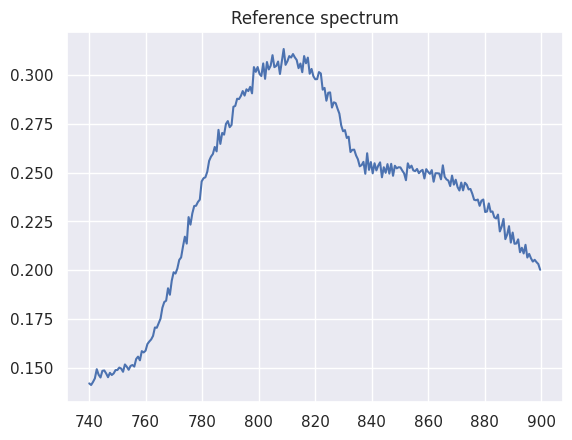

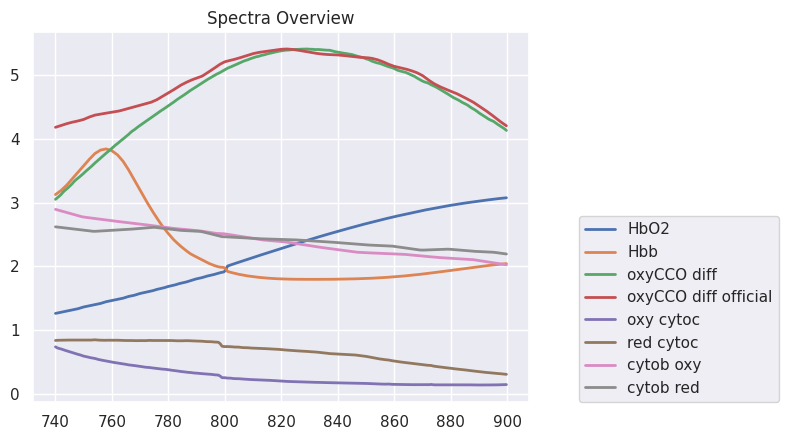

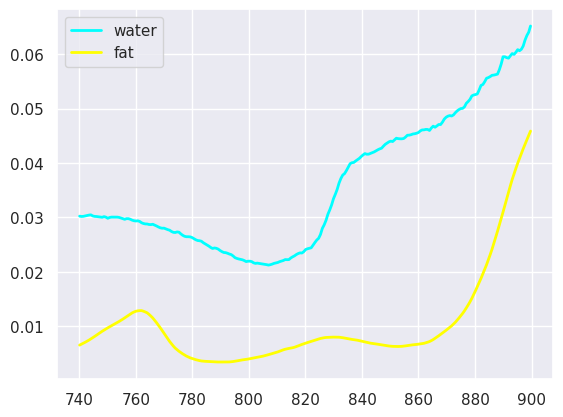

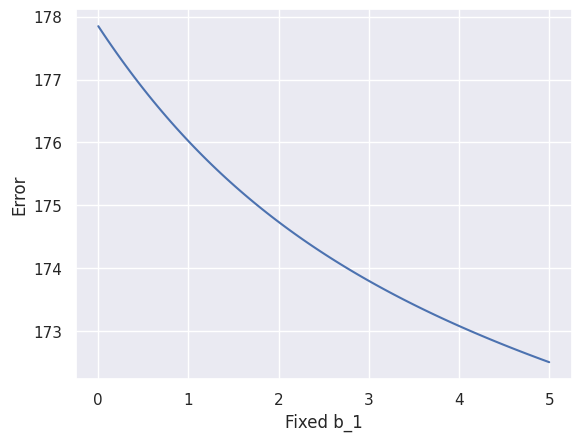

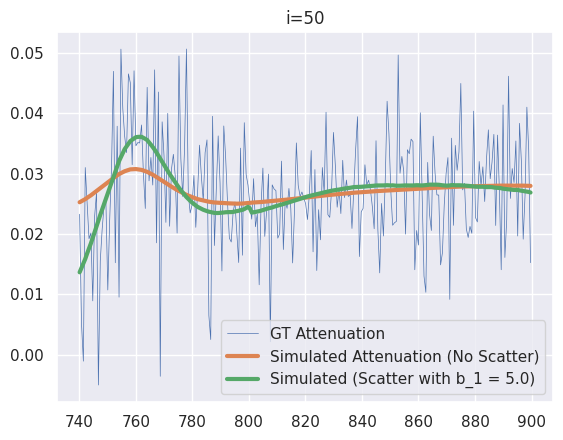

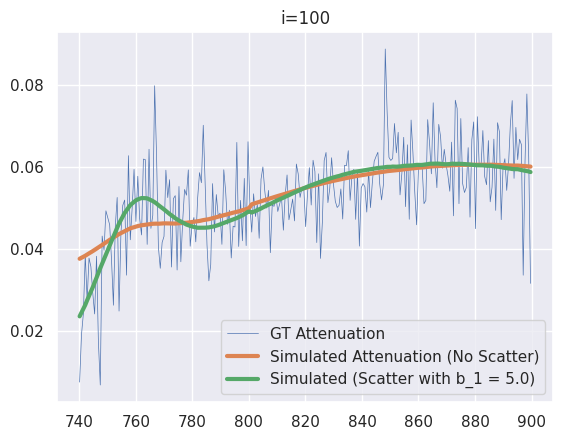

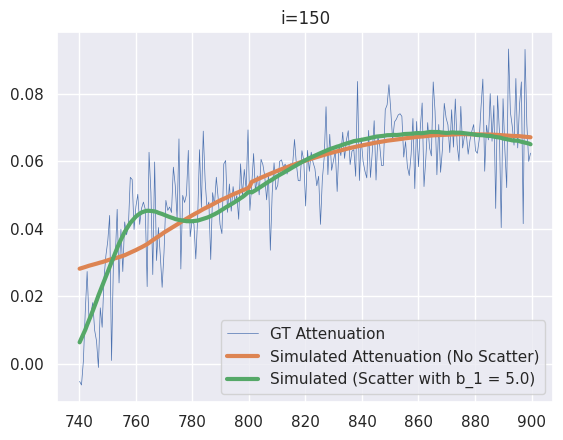

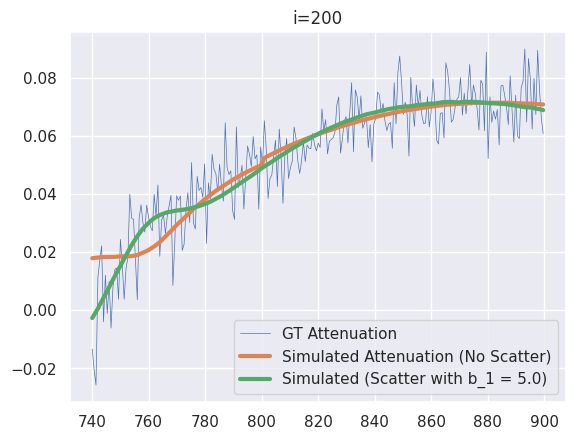

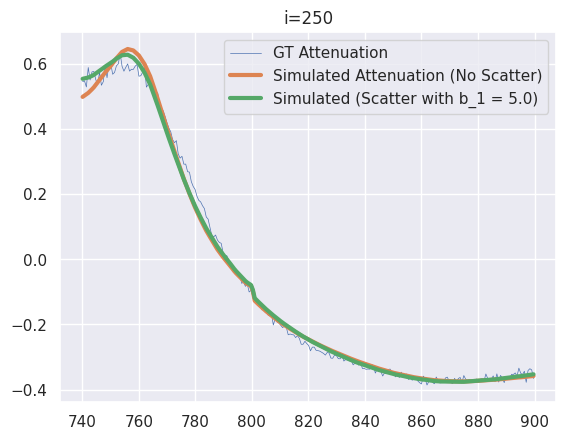

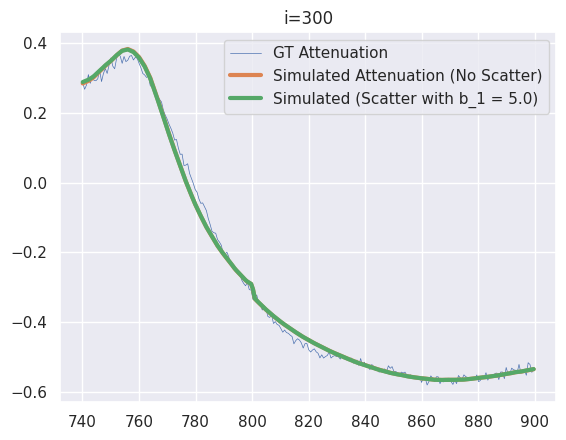

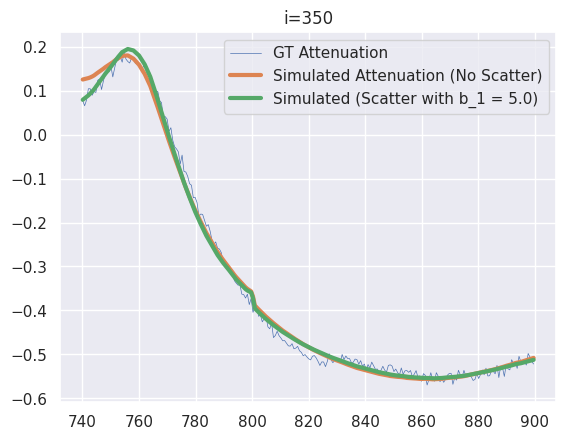

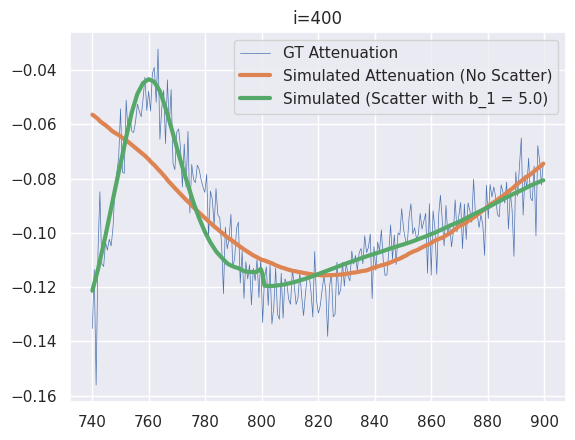

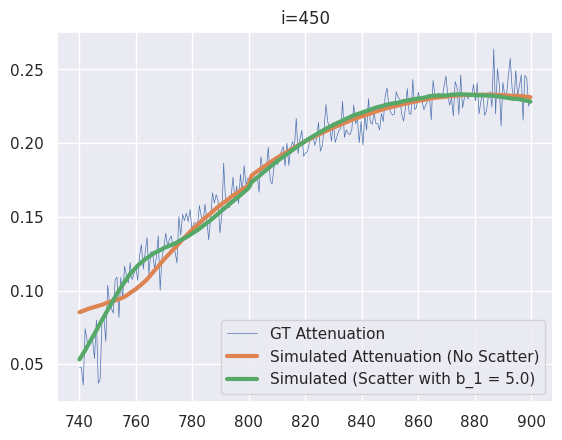

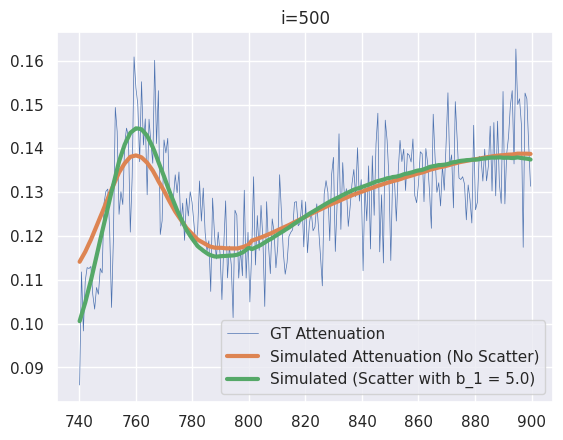

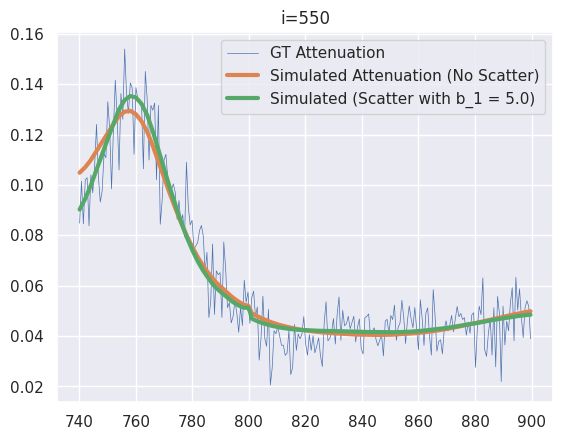

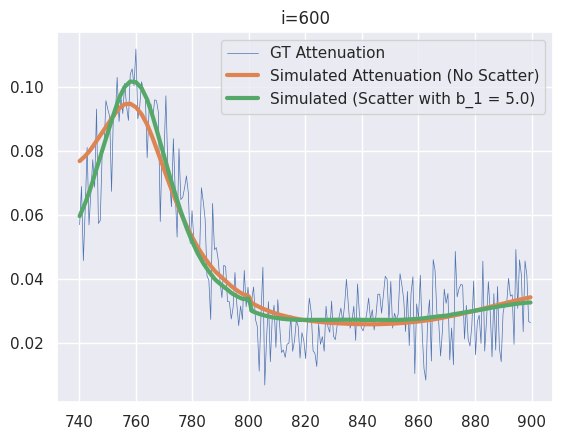

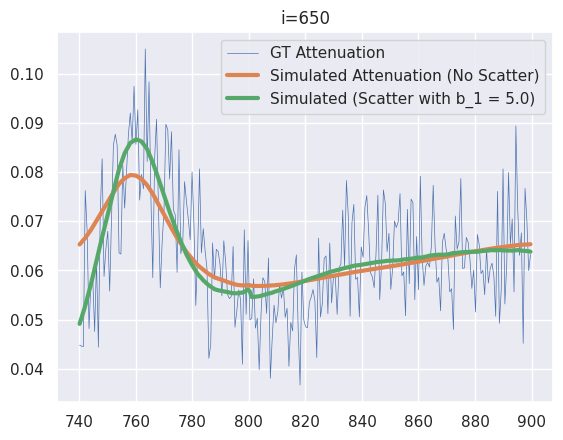

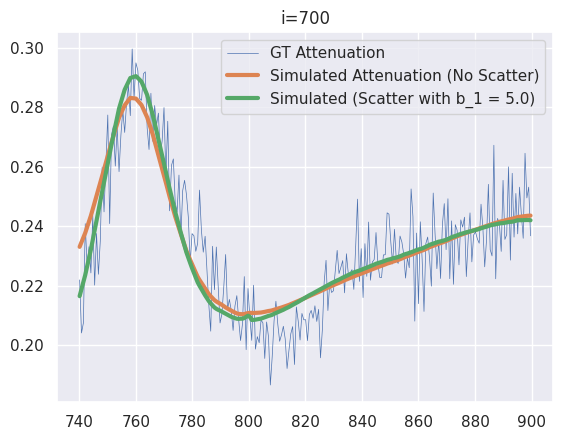

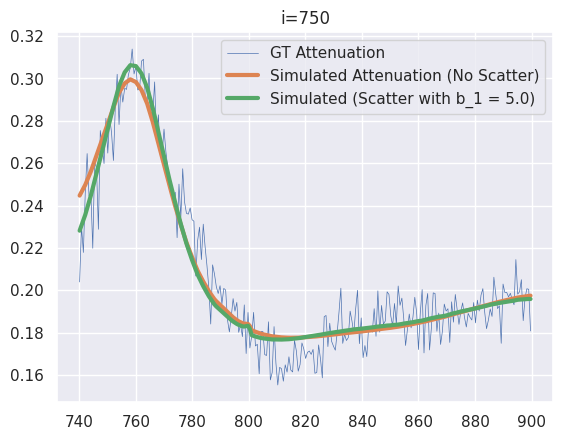

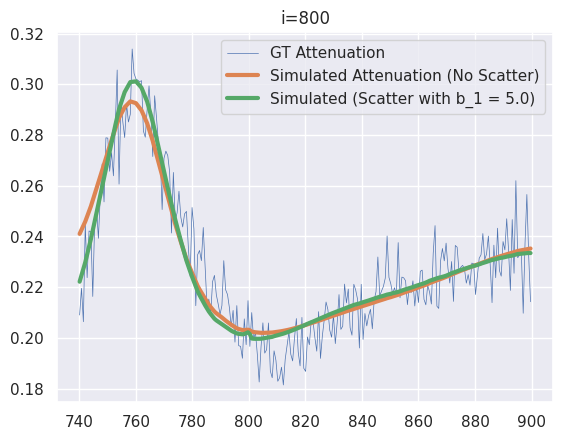

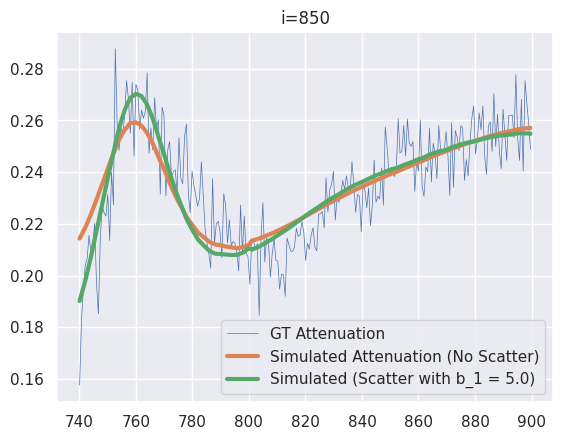

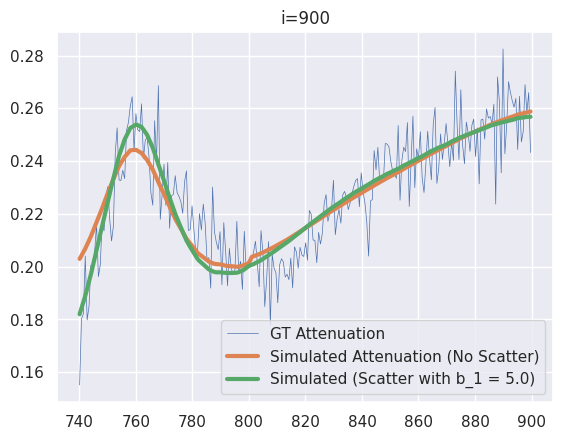

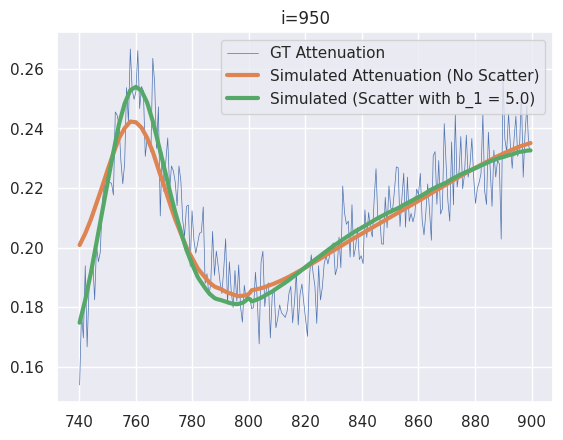

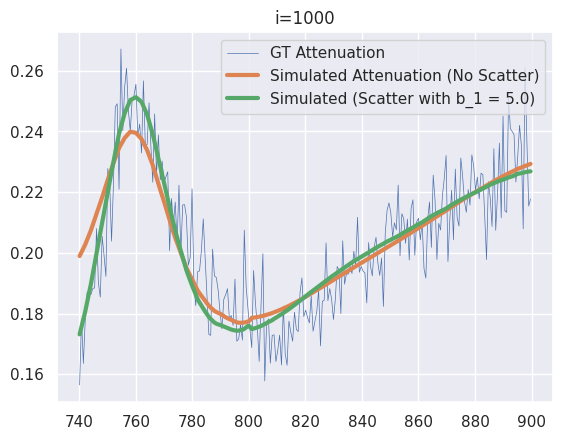

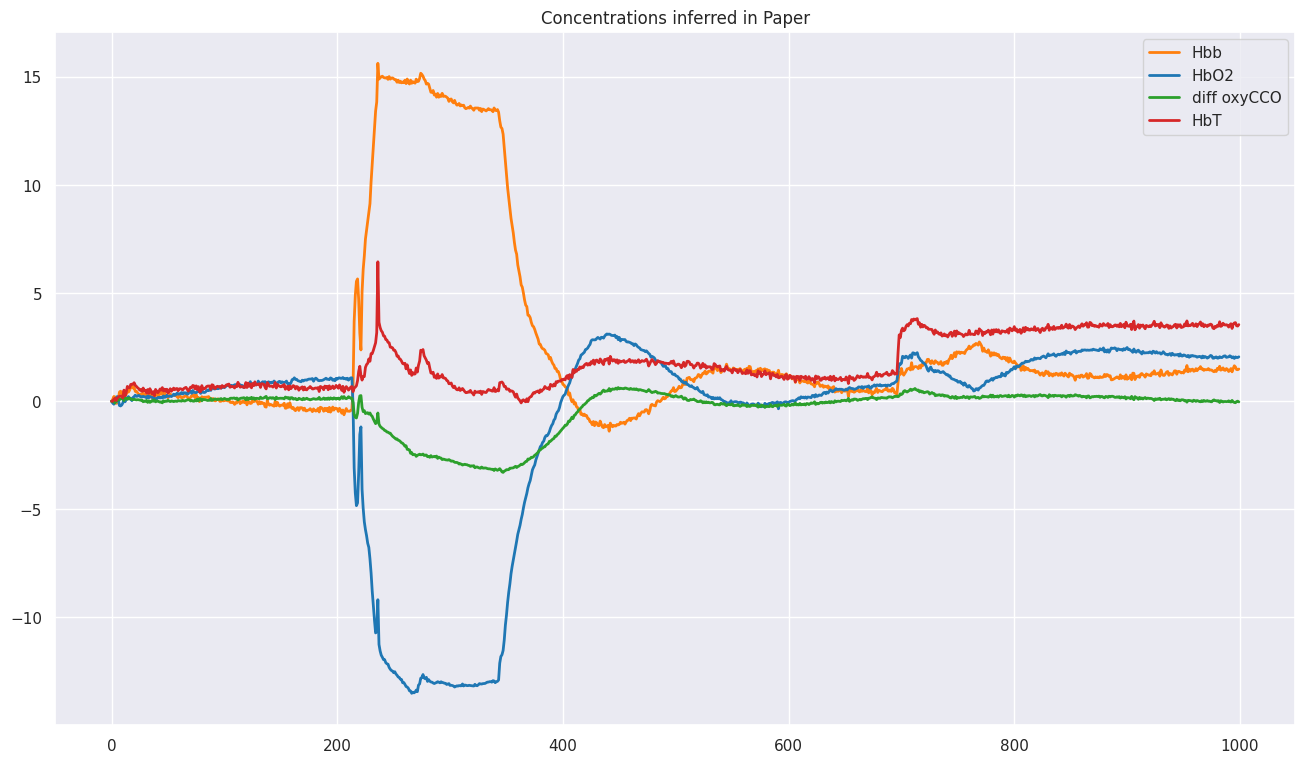

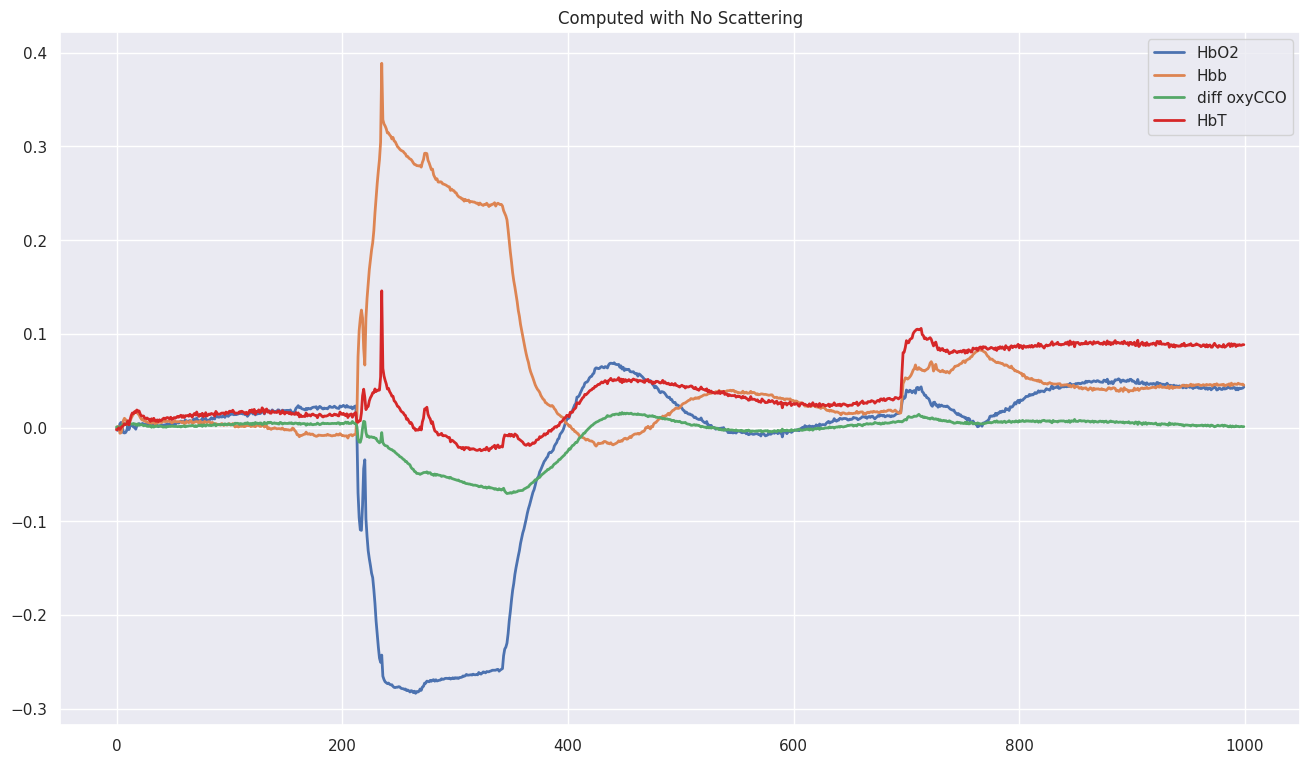

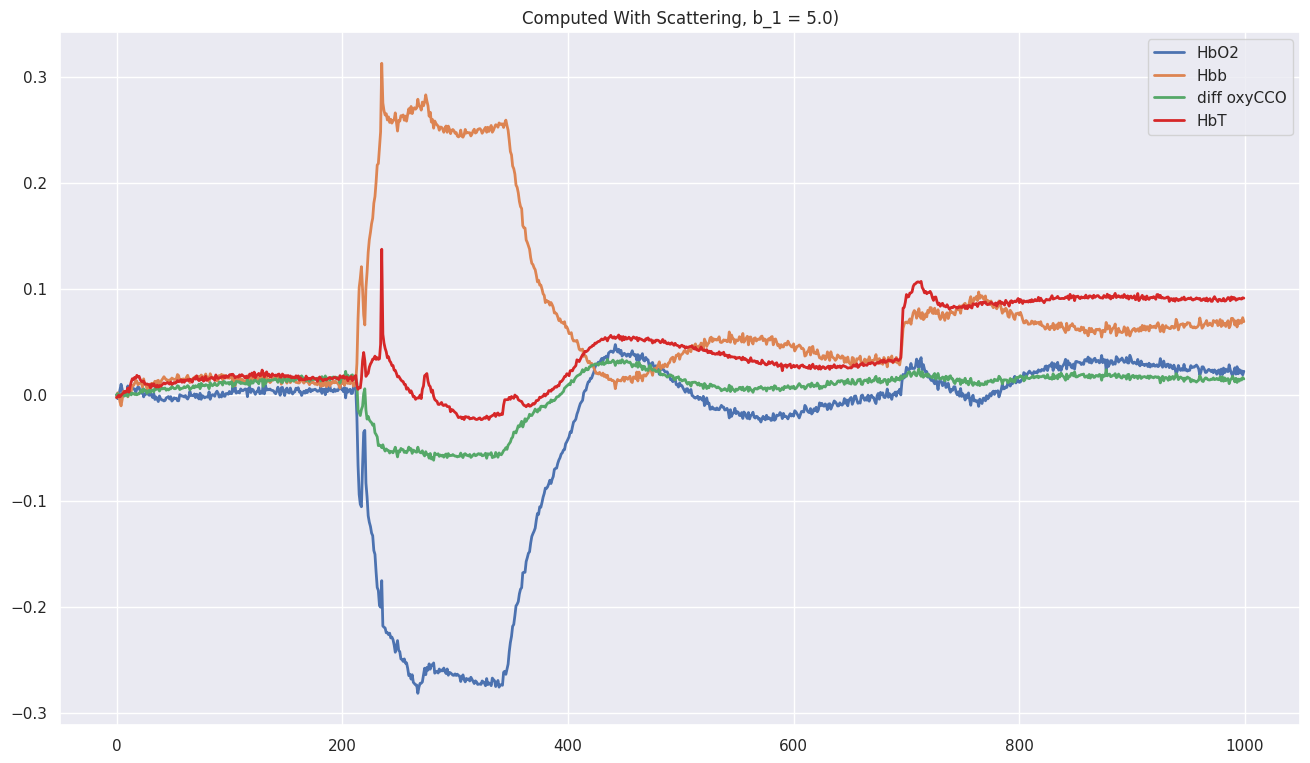

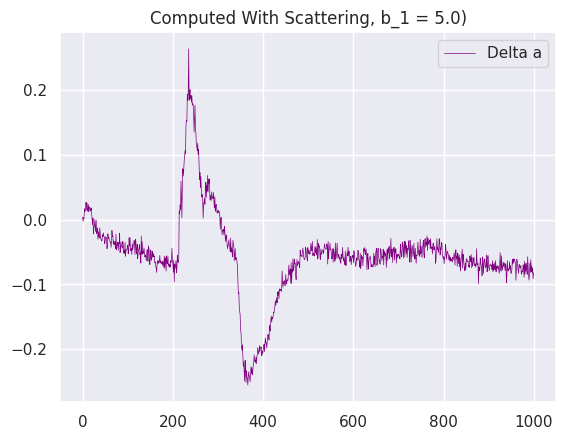

In [20]:
print(scenario_3(img, img_darkcount, img_whitecount, need_plot=True))

# Scenario 4
We assume that
$$
\Delta A(t,\lambda)=\text{PL}(\lambda)\left(\sum_{i}\mu_{i}(\lambda)\cdot\Delta c_{i}(t)+a(t_{2})\cdot\left(\frac{\lambda}{500nm}\right)^{-b(t_{2})}\right)
$$

In [ ]:
import scipy
from scipy.linalg import pinv

def scenario_4(img, img_darkcount, img_whitecount, need_plot=True, plot_only_concentrations=False):
    wavelengths = img['wavelengths'].astype(float)
    white_full = img_whitecount['refSpectrum'].astype(float)
    dark_full = img_darkcount['DarkCount'].astype(float)
    spectr = img['spectralDataAll'].astype(float)

    concentrations_paper = img['AllConcentration']
    
    idx = (wavelengths >= left_cut) & (wavelengths <= right_cut)
    wavelengths = wavelengths[idx]
    spectr = spectr[idx.squeeze()]
    dark_full = dark_full[idx.squeeze()]
    white_full = white_full[idx.squeeze()]

    reference_index = 0
    ref_spectr = (spectr[:, reference_index] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])

    if need_plot:
        plt.figure()
        plt.plot(wavelengths, ref_spectr)
        plt.title("Reference spectrum")
    
    molecules, x = preprocessing.read_molecules(left_cut, right_cut, wavelengths)
    y_hbo2_f, y_hb_f, y_coxa, y_creda, y_water, y_fat, y_cytoa_diff, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red = molecules
    M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                np.asarray(y_hb_f),
                                np.asarray(y_coxa - y_creda))))
    M_pinv = pinv(M)
    m=M.shape[1]

    if need_plot:
        plt.figure()
        coef = ["HbO2", "Hbb", "oxyCCO diff", "oxyCCO diff official", "oxy cytoc", "red cytoc", "cytob oxy", "cytob red"]
        coef_list = [y_hbo2_f, y_hb_f, y_coxa-y_creda, y_cytoa_diff, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red]
        for i in range(len(coef)):
            plt.plot(wavelengths, coef_list[i], label=coef[i], linewidth=2)
        
        plt.title("Spectra Overview")
        plt.legend(loc=(1.1,0))
        
        plt.figure()
        colors = ['cyan', 'yellow']
        coef = ["water", "fat"]
        coef_list = [y_water, y_fat]
        for i in range(len(coef)):
            plt.plot(wavelengths, coef_list[i], color=colors[i], label=coef[i], linewidth=2)
        plt.legend()
    
    #Define helper functions
    def plot_concentrations_paper(concentrations):
        plt.figure(figsize=(16,9))
        coef_list = np.vstack(concentrations)
        colors = ['#ff7f0e', '#1f77b4', '#2ca02c','#d62728']
        coef = ["Hbb","HbO2","diff oxyCCO","HbT"]
        
        for i in range(len(coef)):
            plt.plot(coef_list[:cut, i], label=coef[i], color=colors[i], linewidth=2)
            
        plt.title("Concentrations inferred in Paper")
        plt.legend()
        
            
    def plot_concentrations(coef_list, a_s, title):
        plt.figure(figsize=(16,9))
        coef_list = np.vstack(coef_list)
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        coef = ["HbO2", "Hbb","diff oxyCCO","diff cc red","water","fat"]
        
        for i in range(m):
            if coef[i] == "water" or coef[i] == "fat":
                plt.plot(coef_list[:, i]/10, label=coef[i]+"/10", linewidth=2)
            else:
                plt.plot(coef_list[:, i], label=coef[i], linewidth=2)
            
        plt.plot(coef_list[:, 0] + coef_list[:,1], color='#d62728', label="HbT",linewidth=2)
        plt.title(title)
        plt.legend()
        
        if len(a_s)>0: 
            a_s = np.vstack(a_s)
            plt.figure()
            plt.plot(a_s[:, 0], label="a(t)", linewidth=0.5, color='purple')
            plt.title(title)
            plt.legend()
    
    def plot_a_b(a_s, b_s):
        plt.figure()
        b_s = np.vstack(b_s)
        plt.figure()
        plt.plot(b_s[:, 0], label="b", linewidth=2)
    
    def S(G_tilde, b_i):
        result = (((wavelengths[...,None]/500)**(-b_i[0])) @ G_tilde) / (1-0.9)
        return result
    
    def f(X,*b):
        delta_c_i = X[:m]
        G_tilde_i = X[m:(m+1)]
        b_i = X[(m+1):(m+2)]  
        return (M @ delta_c_i) + S(G_tilde_i, b_i) - b
        
    def optimisation_pinv(spectr1, spectr2):
        b = spectr2 / spectr1
        b = np.log(1 / np.asarray(b))
        X = M_pinv @ b
        found_spectrum = np.exp(-(M @ X)) * spectr1
        
        error = np.linalg.norm((((M @ X)) - b))
        
        return X, b, found_spectrum, error
    
    spectra_list = []
    coef_list = []
    b_s = []
    a_s = []
    
    coef_list_no_scatter = []
    
    coef_list_min_b1 = []
    a_s_min_b1 = []

    errors_no_scatter = []
    errors_scatter = []
    errors_scatter_min_b1 = []
    
    #initial_estimation = [0,0,0,0,1]
    current_x = np.zeros(m+2)
    current_x[-1] = 1
    #left_bound = [-np.inf,-np.inf,-np.inf,-np.inf,-1,0]
    left_bound = np.append(np.ones(m)*(-np.inf), [-np.inf, 0])
    #right_bound = [np.inf,np.inf,np.inf,np.inf,1,0.2]
    right_bound = np.append(np.ones(m)*np.inf, [np.inf, max_b1])
    
    for i in tqdm(range(1, cut+1)):
        spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
        spectr2[spectr2 <= 0] = 0.0001    
        b = spectr2 / ref_spectr
        b = np.log(1 / np.asarray(b))
        result = scipy.optimize.least_squares(f, current_x, args=b, bounds=(left_bound, right_bound))
        result_no_scatter, _, found_spectrum_noscatter, error_no_scatter = optimisation_pinv(ref_spectr, spectr2)
        current_x = result.x
        coef_list.append(result.x[:m])

        coef_list_no_scatter.append(result_no_scatter)
        
        a_s.append(result.x[m])
        b_s.append(result.x[m+1])

        errors_no_scatter.append(error_no_scatter)
        errors_scatter.append(np.sqrt(2*result.cost))
    
        #found_spectrum = np.exp(-(f(result.x, 0))) * ref_spectr
        found_spectrum = (f(result.x, 0))
        
        if need_plot and i % 50 == 0:
            plt.figure()
            plt.plot(wavelengths, -np.log(spectr2 / ref_spectr), label='GT Attenuation', linewidth=0.5)
            plt.plot(wavelengths, -np.log(found_spectrum_noscatter / ref_spectr), label='Simulated Attenuation (No Scatter)', linewidth=3)
            plt.plot(wavelengths, found_spectrum, label='Simulated (Scatter b_1(t))', linewidth=3)
            plt.title("i=" + str(i))
            plt.legend()

    if need_plot:
        plot_concentrations_paper(concentrations_paper)
        plot_concentrations(coef_list_no_scatter, [], "Computed with No Scattering")
        plot_concentrations(coef_list, a_s, "Computed With Scattering, b_1(t)")
        plot_a_b(a_s,b_s)

    if not need_plot and plot_only_concentrations:
        plot_concentrations(coef_list, a_s, "Scenario 4 - Computed With Scattering, b_1(t)")

        
    return sum(errors_no_scatter), sum(errors_scatter)

In [ ]:
scenario_4(img, img_darkcount, img_whitecount, need_plot=True)

# Comparison of different scenarios for single piglet

For timepoints $i=1,\dots,n$, each considered scenario has the following amount of scattering parameters:

- Scenario 1: $2n$ parameters ($n$ linear parameters $a(t_i)$, $n$ nonlinear parameters $b(t_i)$)
- Scenario 2: $n$ parameters ($n$ nonlinear parameters $b(t_i)$)
- Scenario 3: $n+1$ parameters ($n$ linear parameters $\Delta a$, one nonlinear parameter $b$)
- Scenario 4: $2n-2$ parameters ($n-1$ linear parameters, $n-1$ nonlinear parameters)


In [ ]:
b_1, a_1 = scenario_1_search_t1(img, img_darkcount, img_whitecount, need_plot=False)
error_no_scatter_scenario1, error_scenario1 = scenario_1_given_t1(img, img_darkcount, img_whitecount, [a_1], [b_1], need_plot=False, plot_only_concentrations=True)
print("Finished scenario 1 - found a(t_1) = ", a_1, ", b(t_1) = ", b_1)

min_b1 = scenario_2_search_t1(img, img_darkcount, img_whitecount, need_plot=False)
error_no_scatter_scenario2, error_scenario2 = scenario_2_given_t1(img, img_darkcount, img_whitecount, [min_b1], need_plot=False, plot_only_concentrations=True)
print("Finished scenario 2 - found b(t_1) = ", min_b1)

error_no_scatter_scenario3, error_scenario3, min_b1_sc3 = scenario_3(img, img_darkcount, img_whitecount, need_plot=False, plot_only_concentrations=True)
print("Finished scenario 3, found b = ", min_b1_sc3)

error_no_scatter_scenario4, error_scenario4 = scenario_4(img, img_darkcount, img_whitecount, need_plot=False, plot_only_concentrations=True)
print("Finished scenario 4")

assert(error_no_scatter_scenario1 == error_no_scatter_scenario2 == error_no_scatter_scenario3 == error_no_scatter_scenario4)

plt.figure()
x = np.array([0,1,2,3,4])
y = (np.array([error_no_scatter_scenario1, error_scenario2, error_scenario3, error_scenario4, error_scenario1]) - error_no_scatter_scenario1) / error_no_scatter_scenario1
my_xticks = ['No Scatter','Scenario 2','Scenario 3','Scenario 4','Scenario 1']
plt.xticks(x, my_xticks)
plt.plot(x,y)
plt.ylabel("Error: Percentage Change")

# Comparison of different scenarios for 10 piglets

In [ ]:
from tqdm.autonotebook import tqdm

names = []
imgs = []
imgs_darkcount = []
imgs_whitecount = []

names.append("LWP479")
imgs.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/lwp479-HI+saline/LWP479_Ws_05Dec2016.mat'))
imgs_darkcount.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/lwp479-HI+saline/LWP479_DarkCount_05Dec2016.mat'))
imgs_whitecount.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/lwp479-HI+saline/refSpectrum.mat'))

names.append("LWP480")
imgs.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP480/LWP480_Ws_12Dec2016.mat'))
imgs_darkcount.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP480/LWP480_DarkCount_12Dec2016.mat'))
imgs_whitecount.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP480/refSpectrum.mat'))

names.append("LWP484")
imgs.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP484/LWP484_Ws_23Jan2017.mat'))
imgs_darkcount.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP484/LWP484_DarkCount_23Jan2017.mat'))
imgs_whitecount.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP484/refSpectrum.mat'))

names.append("LWP488")
imgs.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP488/LWP488_Ws_13Feb2017.mat'))
imgs_darkcount.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP488/LWP488_DarkCount_13Feb2017.mat'))
imgs_whitecount.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP488/refSpectrum.mat'))

names.append("LWP490")
imgs.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP490/LWP490_Ws_27Feb2017.mat'))
imgs_darkcount.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP490/LWP490_DarkCount_27Feb2017.mat'))
imgs_whitecount.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP490/refSpectrum.mat'))

names.append("LWP498")
imgs.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP498/LWP498_Ws_24Apr2017_15.mat'))
imgs_darkcount.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP498/LWP498 _DarkCount_24Apr2017.mat'))
imgs_whitecount.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP498/refSpectrum.mat'))

names.append("LWP503")
imgs.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP503/LWP503_Ws_05_Jun_2017_15   8.mat'))
imgs_darkcount.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP503/LWP503_DarkCount_05Jun2017.mat'))
imgs_whitecount.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP503/refSpectrum.mat'))

names.append("LWP504")
imgs.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP504/LWP504_Ws_12Jun_2017_17   1.mat'))
imgs_darkcount.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP504/LWP504_DarkCount_12Jun2017.mat'))
imgs_whitecount.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP503/refSpectrum.mat'))

names.append("LWP507")
imgs.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP507/LWP507_Ws_10Jul_2017_16  55.mat'))
imgs_darkcount.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP507/LWP507_DarkCount_10Jul2017.mat'))
imgs_whitecount.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP507/refSpectrum.mat'))

names.append("LWP512")
imgs.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP512/LWP512_Ws_31Jul_2017_17  16.mat'))
imgs_darkcount.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP512/LWP512_DarkCount_31Jul2017.mat'))
imgs_whitecount.append(scipy.io.loadmat('dataset/miniCYRIL Piglet Data/LWP512/refSpectrum.mat'))

In [ ]:
plt.figure()
x = np.array([0,1,2,3,4])
my_xticks = ['No Scatter','Scenario 2','Scenario 3','Scenario 4','Scenario 1']
plt.xticks(x, my_xticks)
plt.ylabel("Error: Percentage Change")

for i in tqdm(range(len(names))):
    img = imgs[i]
    img_darkcount = imgs_darkcount[i]
    img_whitecount = imgs_whitecount[i]
    
    b_1, a_1 = scenario_1_search_t1(img, img_darkcount, img_whitecount, need_plot=False)
    error_no_scatter_scenario1, error_scenario1 = scenario_1_given_t1(img, img_darkcount, img_whitecount, [a_1], [b_1], need_plot=False, plot_only_concentrations=False)
    #print("Finished scenario 1 - found a(t_1) = ", a_1, ", b(t_1) = ", b_1)
    
    min_b1 = scenario_2_search_t1(img, img_darkcount, img_whitecount, need_plot=False)
    error_no_scatter_scenario2, error_scenario2 = scenario_2_given_t1(img, img_darkcount, img_whitecount, [min_b1], need_plot=False, plot_only_concentrations=False)
    #print("Finished scenario 2 - found b(t_1) = ", min_b1)
    
    error_no_scatter_scenario3, error_scenario3, min_b1_sc3 = scenario_3(img, img_darkcount, img_whitecount, need_plot=False, plot_only_concentrations=False)
    #print("Finished scenario 3, found b = ", min_b1_sc3)
    
    error_no_scatter_scenario4, error_scenario4 = scenario_4(img, img_darkcount, img_whitecount, need_plot=False, plot_only_concentrations=False)
    #print("Finished scenario 4")
    y = (np.array([error_no_scatter_scenario1, error_scenario2, error_scenario3, error_scenario4, error_scenario1]) - error_no_scatter_scenario1) / error_no_scatter_scenario1
    plt.plot(x,y,label=names[i])

plt.legend()

# Comparison of scenarios 2 and 3 for 10 piglets

In [ ]:
ys = []


for i in tqdm(range(len(names))):
    img = imgs[i]
    img_darkcount = imgs_darkcount[i]
    img_whitecount = imgs_whitecount[i]
    
    min_b1 = scenario_2_search_t1(img, img_darkcount, img_whitecount, need_plot=False)
    error_no_scatter_scenario2, error_scenario2 = scenario_2_given_t1(img, img_darkcount, img_whitecount, [min_b1], need_plot=False, plot_only_concentrations=True)
    
    error_no_scatter_scenario3, error_scenario3, min_b1_sc3 = scenario_3(img, img_darkcount, img_whitecount, need_plot=False, plot_only_concentrations=True)
    
    error_no_scatter_scenario4, error_scenario4 = scenario_4(img, img_darkcount, img_whitecount, need_plot=False, plot_only_concentrations=True)

    assert(error_no_scatter_scenario2 == error_no_scatter_scenario3 == error_no_scatter_scenario4)
    
    y = (np.array([error_no_scatter_scenario2, error_scenario2, error_scenario3, error_scenario4]) - error_no_scatter_scenario2) / error_no_scatter_scenario2
    ys.append(y)

In [ ]:
plt.figure()
x = np.array([0,1,2,3])
my_xticks = ['No Scatter','Scenario 2','Scenario 3','Scenario 4']
plt.xticks(x, my_xticks)
plt.ylabel("Error: Percentage Change")
for i in range(len(names)):
    plt.plot(x,ys[i],label=names[i])
plt.legend()

# Scattering + Water

In [ ]:
left_cut = 740
right_cut = 930

min_b1 = scenario_2_search_t1(img, img_darkcount, img_whitecount, include_water=True)
scenario_2_given_t1(img, img_darkcount, img_whitecount, [min_b1], need_plot=True, include_water=True)

In [ ]:
scenario_3(img, img_darkcount, img_whitecount, need_plot=True, include_water=True)

# Scenario 1 with RF

In [ ]:
import scipy
from scipy.linalg import pinv

def scenario_1_given_t1(img, img_darkcount, img_whitecount, b_i_t1, G_tilde_t1, need_plot=True, plot_only_concentrations=False):

    #Initialization
    wavelengths = img['wavelengths'].astype(float)
    white_full = img_whitecount['refSpectrum'].astype(float)
    dark_full = img_darkcount['DarkCount'].astype(float)
    spectr = img['spectralDataAll'].astype(float)

    concentrations_paper = img['AllConcentration']
    
    idx = (wavelengths >= left_cut) & (wavelengths <= right_cut)
    wavelengths = wavelengths[idx]
    spectr = spectr[idx.squeeze()]
    dark_full = dark_full[idx.squeeze()]
    white_full = white_full[idx.squeeze()]

    reference_index = 0
    ref_spectr = (spectr[:, reference_index] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])

    if need_plot:
        plt.figure()
        plt.plot(wavelengths, ref_spectr)
        plt.title("Reference spectrum")
    
    molecules, x = preprocessing.read_molecules(left_cut, right_cut, wavelengths)
    y_hbo2_f, y_hb_f, y_coxa, y_creda, y_water, y_fat, y_cytoa_diff, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red = molecules
    print(np.asarray(y_hbo2_f).shape)
    M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                np.asarray(y_hb_f),
                                np.asarray(y_cytoa_diff))))
    M_pinv = pinv(M)
    m=M.shape[1]

    print(M.shape)

    if need_plot:
        plt.figure()
        coef = ["HbO2", "Hbb", "oxyCCO diff", "oxyCCO diff official", "oxy cytoc", "red cytoc", "cytob oxy", "cytob red"]
        coef_list = [y_hbo2_f, y_hb_f, y_coxa-y_creda, y_cytoa_diff, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red]
        for i in range(len(coef)):
            plt.plot(wavelengths, coef_list[i], label=coef[i], linewidth=2)
        
        plt.title("Spectra Overview")
        plt.legend(loc=(1.1,0))
        
        plt.figure()
        colors = ['cyan', 'yellow']
        coef = ["water", "fat"]
        coef_list = [y_water, y_fat]
        for i in range(len(coef)):
            plt.plot(wavelengths, coef_list[i], color=colors[i], label=coef[i], linewidth=2)
        plt.legend()
    
    #Define helper functions

    def RF_calc(concentrations):
        coef_list = np.vstack(concentrations)
        nadir = np.min(coef_list[HI_start:HI_stop,2])
        recovery = np.mean(coef_list[HI_stop:(HI_stop+180),2])
        baseline = np.mean(coef_list[:HI_start,2])

        RF_found = (recovery - nadir) / (baseline - nadir)
        return RF_found
    
    def plot_concentrations_paper(concentrations):
        plt.figure(figsize=(16,9))
        coef_list = np.vstack(concentrations)
        colors = ['#ff7f0e', '#1f77b4', '#2ca02c','#d62728']
        coef = ["Hbb","HbO2","diffCCO","HbT"]
        
        for i in range(len(coef)):
            plt.plot(coef_list[:cut, i], label=coef[i], color=colors[i], linewidth=2)

        y_min, y_max = plt.gca().get_ylim()
        #plt.vlines([HI_start, HI_stop],y_min,y_max,linestyles='dashed',label='HI Period',colors='gray')
        plt.axvline(x=HI_start,color='gray',linestyle='--',label='HI + Recovery',alpha=0.6)
        plt.axvline(x=HI_stop,color='gray',linestyle='--',alpha=0.6)
        plt.axvline(x=HI_stop+180,color='gray',linestyle='--',alpha=0.6)
        plt.title("Concentrations inferred in Paper, oxCCO RF = "+str(np.round(RF_calc(concentrations),3)))
        plt.legend()
             
    def plot_concentrations(coef_list, a_s, title):
        plt.figure(figsize=(16,9))
        RF_oxCCO = np.round(RF_calc(coef_list),3)
        coef_list = np.vstack(coef_list)
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        coef = ["HbO2", "Hbb","diffCCO","diff cc red","water","fat"]
        
        for i in range(m):
            if coef[i] == "water" or coef[i] == "fat":
                plt.plot(coef_list[:, i]/10, label=coef[i]+"/10", linewidth=2)
            else:
                plt.plot(coef_list[:, i], label=coef[i], linewidth=2)
            
        plt.plot(coef_list[:, 0] + coef_list[:,1], color='#d62728', label="HbT",linewidth=2)

        plt.axvline(x=HI_start,color='gray',linestyle='--',label='HI + Recovery',alpha=0.6)
        plt.axvline(x=HI_stop,color='gray',linestyle='--',alpha=0.6)
        plt.axvline(x=HI_stop+180,color='gray',linestyle='--',alpha=0.6)
        
        plt.title(title + ", oxCCO RF = " + str(RF_oxCCO))
        plt.legend()
        
        if len(a_s)>0: 
            a_s = np.vstack(a_s)
            plt.figure()
            plt.plot(a_s[:, 0], label="a_1", linewidth=0.5, color='purple')
            plt.title(title)
            plt.legend()
    
    def plot_a_b(a_s, b_s):
        plt.figure()
        b_s = np.vstack(b_s)
        plt.figure()
        plt.plot(b_s[:, 0], label="b", linewidth=2)
    
    def S(G_tilde, b_i, b_i_t1, G_tilde_t1):
        result = ((((wavelengths[...,None]/500)**(-b_i[0])) @ G_tilde) - (((wavelengths[...,None]/500)**(-b_i_t1[0])) @ G_tilde_t1)) / (1-0.9)
        return result
    
    def f(X,*arg):
        b = arg[0]
        b_i_t1, G_tilde_t1 = arg[1], arg[2]
        delta_c_i = X[:m]
        G_tilde_i = X[m:(m+1)]
        b_i = X[(m+1):(m+2)]  
        return (M @ delta_c_i) + S(G_tilde_i, b_i, b_i_t1, G_tilde_t1) - b
        
    def optimisation_pinv(spectr1, spectr2):
        b = spectr2 / spectr1
        b = np.log(1 / np.asarray(b))
        X = M_pinv @ b
        found_spectrum = np.exp(-(M @ X)) * spectr1
        
        error = np.linalg.norm((((M @ X)) - b))
        
        return X, b, found_spectrum, error

    def optimisation_scattering_pinv(spectr1, spectr2, b_1):
        S = ((((wavelengths[...,None]/500)**(-b_1)))) / (1 - 0.9)
        M_S = np.hstack((M,S))
        M_S_pinv = pinv(M_S)
        b = spectr2 / spectr1
        b = np.log(1 / np.asarray(b))
        X = M_S_pinv @ b
        delta_c_i = X[0:m]
        delta_g_i_times_a_i = X[m:]
        found_spectrum = np.exp(-((M @ delta_c_i) + (S @ delta_g_i_times_a_i))) * spectr1
    
        error = np.linalg.norm(((((M @ delta_c_i) + (S @ delta_g_i_times_a_i))) - b))
    
        return X, b, found_spectrum, error
    
    def run_opti_b1(b_1):
        errors = []
        errors_no_scatter = []
        for i in range(1, cut+1):
            spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
            spectr2[spectr2 <= 0] = 0.0001    
            b = spectr2 / ref_spectr
            b = np.log(1 / np.asarray(b))
            _, _, _, error_no_scatter = optimisation_pinv(ref_spectr, spectr2)
            _, _, _, error = optimisation_scattering_pinv(ref_spectr, spectr2, b_1)
            errors.append(error)
            errors_no_scatter.append(error_no_scatter)
        return sum(errors), sum(errors_no_scatter)

    def plot_errors(no_scatter, scatter_fixed_b1, scatter, min_b1):
        plt.figure()
        x = np.array([0,1,2])
        #x = np.array([0,1])
        y = (np.array([no_scatter, scatter_fixed_b1, scatter]) - no_scatter) / no_scatter
        #y = (np.array([no_scatter, scatter_fixed_b1]) - no_scatter) / no_scatter
        my_xticks = ['No Scatter','Scatter b_1 = '+str(round(min_b1,2)), 'Scatter b_1(t)']
        #my_xticks = ['No Scatter','Scatter b_1 = '+str(round(min_b1,2))]
        plt.xticks(x, my_xticks)
        plt.plot(x,y)
        plt.ylabel("Error: Percentage Change")
    
    spectra_list = []
    coef_list = []
    b_s = []
    a_s = []
    
    coef_list_no_scatter = []
    
    coef_list_min_b1 = []
    a_s_min_b1 = []

    errors_no_scatter = []
    errors_scatter = []
    errors_scatter_min_b1 = []
    
    #initial_estimation = [0,0,0,0,1]
    current_x = np.zeros(m+2)
    current_x[-2] = G_tilde_t1[0]
    current_x[-1] = b_i_t1[0]
    #left_bound = [-np.inf,-np.inf,-np.inf,-np.inf,-1,0]
    left_bound = np.append(np.ones(m)*(-np.inf), [-np.inf, 0])
    #right_bound = [np.inf,np.inf,np.inf,np.inf,1,0.2]
    right_bound = np.append(np.ones(m)*np.inf, [np.inf, max_b1])
    
    for i in range(1, cut+1):
        #ref_spectr = (spectr[:, i-1] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
        spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
        spectr2[spectr2 <= 0] = 0.0001    
        b = spectr2 / ref_spectr
        b = np.log(1 / np.asarray(b))
        result = scipy.optimize.least_squares(f, current_x, args=(b, b_i_t1, G_tilde_t1), bounds=(left_bound, right_bound))
        result_no_scatter, _, found_spectrum_noscatter, error_no_scatter = optimisation_pinv(ref_spectr, spectr2)
        #coefs_min_b1, _, found_spectrum_min_b1, error_scatter_min_b1 = optimisation_scattering_pinv(ref_spectr, spectr2, min_b1)
        current_x = result.x
        coef_list.append(result.x[:m])

        coef_list_no_scatter.append(result_no_scatter)
        
        a_s.append(result.x[m])
        b_s.append(result.x[m+1])

        errors_no_scatter.append(error_no_scatter)
        errors_scatter.append(np.sqrt(2*result.cost))
    
        found_spectrum = f(result.x, *(0,b_i_t1, G_tilde_t1))
        
        if need_plot and i % 50 == 0:
            plt.figure()
            plt.plot(wavelengths, -np.log(spectr2 / ref_spectr), label='GT Attenuation', linewidth=0.5)
            plt.plot(wavelengths, -np.log(found_spectrum_noscatter / ref_spectr), label='Simulated Attenuation (No Scatter)', linewidth=3)
            plt.plot(wavelengths, found_spectrum, label='Simulated (Scatter b_1(t))', linewidth=3)
            #plt.plot(wavelengths, -np.log(found_spectrum_min_b1 / ref_spectr), label='Simulated (Scatter with b_1 = ' + str(round(min_b1,2)) + ')', linewidth=3)
            plt.title("i=" + str(i))
            plt.legend()

    if need_plot:
        plot_concentrations_paper(concentrations_paper)
        plot_concentrations(coef_list_no_scatter, [], "Computed with No Scattering")
        plot_concentrations(coef_list, a_s, "Scenario 1 - Computed With Scattering, b_1(t)")
        plot_a_b(a_s,b_s)

    if not need_plot and plot_only_concentrations:
        plot_concentrations_paper(concentrations_paper)
        plot_concentrations(coef_list, a_s, "Scenario 1 - Computed With Scattering, b_1(t)")
    return sum(errors_no_scatter), sum(errors_scatter), RF_calc(coef_list)

In [ ]:
def scenario_1_search_t1(img, img_darkcount, img_whitecount, need_plot=True):
    bs_i_t1 = np.linspace(0, max_b1, 8)
    Gs_tilde_t1 = np.linspace(0,70,5)
    
    bs_i_t1, Gs_tilde_t1 = np.meshgrid(bs_i_t1, Gs_tilde_t1)
    min_val = np.zeros(bs_i_t1.shape)
    RFs = np.zeros(bs_i_t1.shape)
    
    for i in tqdm(range(bs_i_t1.shape[0])):
        for j in range(bs_i_t1.shape[1]):
            _, min_val[i,j], RFs[i,j] = scenario_1_given_t1(img, img_darkcount, img_whitecount, [bs_i_t1[i,j]], [Gs_tilde_t1[i,j]], need_plot=False)
            #print(bs_i_t1[i,j], Gs_tilde_t1[i,j], min_val[i,j])

    if need_plot:
        plt.figure()
        plt.pcolormesh(bs_i_t1, Gs_tilde_t1, min_val)
        plt.xlabel("b(t_1)")
        plt.ylabel("a(t_1)")
        plt.colorbar()
        plt.title("Errors")
        plt.figure()
        plt.pcolormesh(bs_i_t1, Gs_tilde_t1, RFs)
        plt.xlabel("b(t_1)")
        plt.ylabel("a(t_1)")
        plt.colorbar()
        plt.title("RFs oxCCO")

    min_val_index = np.unravel_index(min_val.argmin(), min_val.shape)
    
    return bs_i_t1[min_val_index[0], min_val_index[1]], Gs_tilde_t1[min_val_index[0], min_val_index[1]]

In [ ]:
a_1, b_1 = scenario_1_search_t1(img, img_darkcount, img_whitecount)
scenario_1_given_t1(img, img_darkcount, img_whitecount, [a_1], [b_1], need_plot=True)

In [ ]:
x